In [2]:
from pyuvdata import UVData
uvd = UVData()
uvd.read_miriad('zen.2458101.65493.xx.HH.uv')

In [29]:
uvd.ant_1_array.shape

(82680,)

In [31]:
uvd.ant_2_array.shape

(82680,)

In [ ]:
uvd.

In [20]:
np.array(uvd.get_antpairs()).shape

(1378, 2)

In [21]:
uvd.time_array.shape

(82680,)

In [22]:
uvd.freq_array.shape

(1, 1024)

In [24]:
uvd.lst_array.shape

(82680,)

In [25]:
uvd.polarization_array

array([-5])

In [27]:
uvd.baseline_array

(82680,)

In [10]:

antpairs = uvd.get_antpairs()
freqs = np.unique(uvd.freq_array)
times = np.unique(uvd.time_array)
uvd.polarization_array




#antpos = odict(zip(ants, antpos))
#pols = np.array([polnum2str[polnum] for polnum in ])

In [13]:
lsts = []
for l in uvd.lst_array.ravel():
    if l not in lsts:
        lsts.append(l)
lsts = np.array(lsts)
antpos, ants = uvd.get_ENU_antpos(center=True, pick_data_ants=True)

np.savez('test.npz', antpairs=uvd.get_antpairs(), polarization_array=uvd.polarization_array,
         freqs=np.unique(uvd.freq_array), times=np.unique(uvd.time_array), 
         lsts=lsts, antpos=antpos, ants=ants)

In [16]:
test = np.load('test.npz')

[[  0   0]
 [  0   1]
 [  0   2]
 ..., 
 [142 142]
 [142 143]
 [143 143]]


In [18]:
len(uvd.lst_array.ravel())

82680

In [6]:
import hera_cal as hc
from hera_cal.abscal_funcs import *
from hera_cal.abscal import AbsCal
import numpy as np
from copy import deepcopy
import glob
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib notebook

In [84]:
#data_file = 'zen.2458101.44615.xx.HH.uvO/'
data_file = 'zen.2458101.65493.xx.HH.uvO/'
model_files = sorted(glob.glob('zen.*.uvXR'))
refant=53
calfits_infile='zen.2458101.65493.xx.HH.uv.omni.calfits'
verbose=True
overwrite=True
write_calfits=True
bl_cut=5000
bl_taper_fwhm=None
output_calfits_fname='interactive.abs.calfits'
return_gains=False
return_object=False 
outdir='.'
match_red_bls=False
tol=1.0
reweight=False
rephase_model=True
all_antenna_gains=True
window=None
edge_cut=300
delay_cal=False
avg_phs_cal=False
avg_dly_slope_cal=True
delay_slope_cal=True
phase_slope_cal=True
abs_amp_cal=True
TT_phs_cal=True
phs_max_iter=5
phs_conv_crit=1e-6
gen_amp_cal=False
gen_phs_cal=False
latitude=-30.72152
max_dlst=0.005
history=''

In [85]:
model_files = sorted(set(match_times(data_file, model_files)))

# check length of model files
nomodelfiles = False
if len(model_files) == 0:
    echo("no model files overlap with data files in LST", verbose=verbose)
    nomodelfiles = True

# load model files
if nomodelfiles == False:
    echo ("loading model file(s)", type=1, verbose=verbose)
    (model, model_flags, model_antpos, model_ants, model_freqs, model_times, model_lsts,
        model_pols) = io.load_vis(model_files, pop_autos=True, return_meta=True)
    antpos = model_antpos
    model_lsts[model_lsts < model_lsts[0]] += 2*np.pi

# check output filepath
if write_calfits:
    # configure filename
    if output_calfits_fname is None:
        output_calfits_fname = os.path.basename(data_file) + '.abscal.calfits'
    if outdir is None:
        outdir = os.path.dirname(data_file)
    output_calfits_path = os.path.join(outdir, output_calfits_fname)

    # check path
    if os.path.exists(output_calfits_path) and overwrite == False:
        raise IOError("{} exists, not overwriting".format(output_calfits_path))

# load data and configure weights
echo("loading {}".format(data_file), type=1, verbose=verbose)
(data, data_flags, data_antpos, data_ants, data_freqs, data_times, data_lsts,
    data_pols) = io.load_vis(data_file, pop_autos=True, return_meta=True, pick_data_ants=False)
bls = odict(map(lambda k: (k, data_antpos[k[0]] - data_antpos[k[1]]), data.keys()))
Ntimes = len(data_times)
Nfreqs = len(data_freqs)
data_lsts[data_lsts < data_lsts[0]] += 2*np.pi

# get data ants
total_data_antpos = copy.deepcopy(data_antpos)
data_ants = np.unique(map(lambda k: k[:2], data.keys()))
data_antpos = odict(map(lambda k: (k, data_antpos[k]), data_ants))

# get wgts
wgts = DataContainer(odict(map(lambda k: (k, (~data_flags[k]).astype(np.float)), data_flags.keys())))

# match redundant baselines
if match_red_bls:
    data = match_red_baselines(data, data_antpos, model, model_antpos, tol=tol, verbose=verbose)
    antpos = model_antpos

# rephase model to match data lst grid
if rephase_model:
    new_model, new_flags = rephase_vis(model, model_lsts, data_lsts, bls, data_freqs, inplace=True,
                                       flags=model_flags, latitude=latitude, max_dlst=max_dlst)
    # set wgts to zero wheree model is flagged
    for k in new_flags.keys():
        wgts[k][new_flags[k]] *= 0
else:
    new_model = model

# reweight according to redundancy
if reweight:
    wgts = mirror_data_to_red_bls(wgts, model_antpos, tol=tol, weights=True)


loading model file(s)
----------------------------------------

loading zen.2458101.65493.xx.HH.uvO/
----------------------------------------


In [86]:
# instantiate class
AC = AbsCal(deepcopy(new_model), deepcopy(data), wgts=deepcopy(wgts), refant=refant, 
            antpos=antpos, freqs=data_freqs, bl_cut=bl_cut, bl_taper_fwhm=bl_taper_fwhm)
refant = AC.refant

# center total_data_antpos w/ refant
total_data_antpos = odict(map(lambda k: (k, total_data_antpos[k] - total_data_antpos[refant]), total_data_antpos.keys()))

# construct total_gain_keys
total_gain_keys = flatten(map(lambda p: map(lambda k: (k, p), total_data_antpos.keys()), AC.gain_pols))

# initialize empty gain_list
merged_gains = []

# perform various calibration routines
if delay_cal:
    if all_antenna_gains:
        raise ValueError("can't run delay_cal when all_antenna_gains is True")
    AC.delay_lincal(verbose=verbose, time_avg=False, window=window, edge_cut=edge_cut)
    result_gains = merge_gains((AC.ant_dly_gain, AC.ant_dly_phi_gain))
    cal_flags = odict(map(lambda k: (k, np.zeros_like(result_gains[k], np.bool)), result_gains.keys()))
    apply_cal.recalibrate_in_place(AC.data, AC.wgts, result_gains, cal_flags, gain_convention='divide')
    merged_gains.append(AC.ant_dly_gain)
    merged_gains.append(AC.ant_dly_phi_gain)
    merged_gains = [merge_gains(merged_gains)]

In [5]:
if avg_dly_slope_cal:
    AC.delay_slope_lincal(verbose=verbose, time_avg=True, window=window, edge_cut=edge_cut)
    cal_flags = odict(map(lambda k: (k, np.zeros_like(AC.dly_slope_gain[k], np.bool)), AC.dly_slope_gain.keys()))
    apply_cal.recalibrate_in_place(AC.data, AC.wgts, AC.dly_slope_gain, cal_flags, gain_convention='divide')
    if all_antenna_gains:
        merged_gains.append(AC.custom_dly_slope_gain(total_gain_keys, total_data_antpos))
    else:
        merged_gains.append(AC.dly_slope_gain)
    merged_gains = [merge_gains(merged_gains)]

after_avg_dly_slope_cal = deepcopy(merged_gains)

...configuring linsolve data for delay_slope_lincal


divide by zero encountered in divide
invalid value encountered in divide
invalid value encountered in double_scalars


...running linsolve
...finished linsolve


In [5]:
if delay_slope_cal:
    AC.delay_slope_lincal(verbose=verbose, time_avg=False, window=window, edge_cut=edge_cut)
    cal_flags = odict(map(lambda k: (k, np.zeros_like(AC.dly_slope_gain[k], np.bool)), AC.dly_slope_gain.keys()))


...configuring linsolve data for delay_slope_lincal


divide by zero encountered in divide
invalid value encountered in divide
invalid value encountered in double_scalars


...running linsolve
...finished linsolve


(60, 1024)


<IPython.core.display.Javascript object>


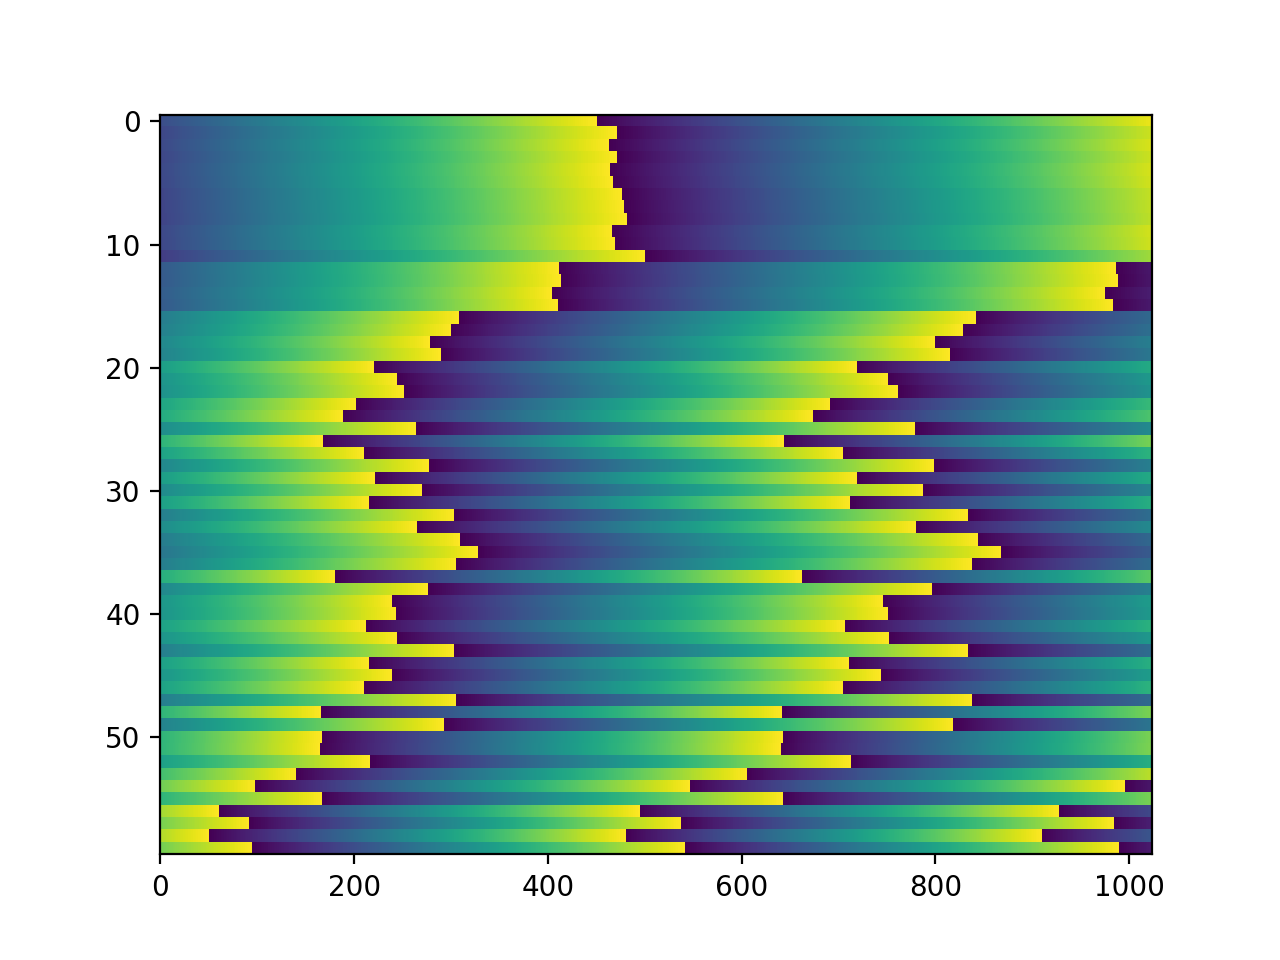

<IPython.core.display.Javascript object>


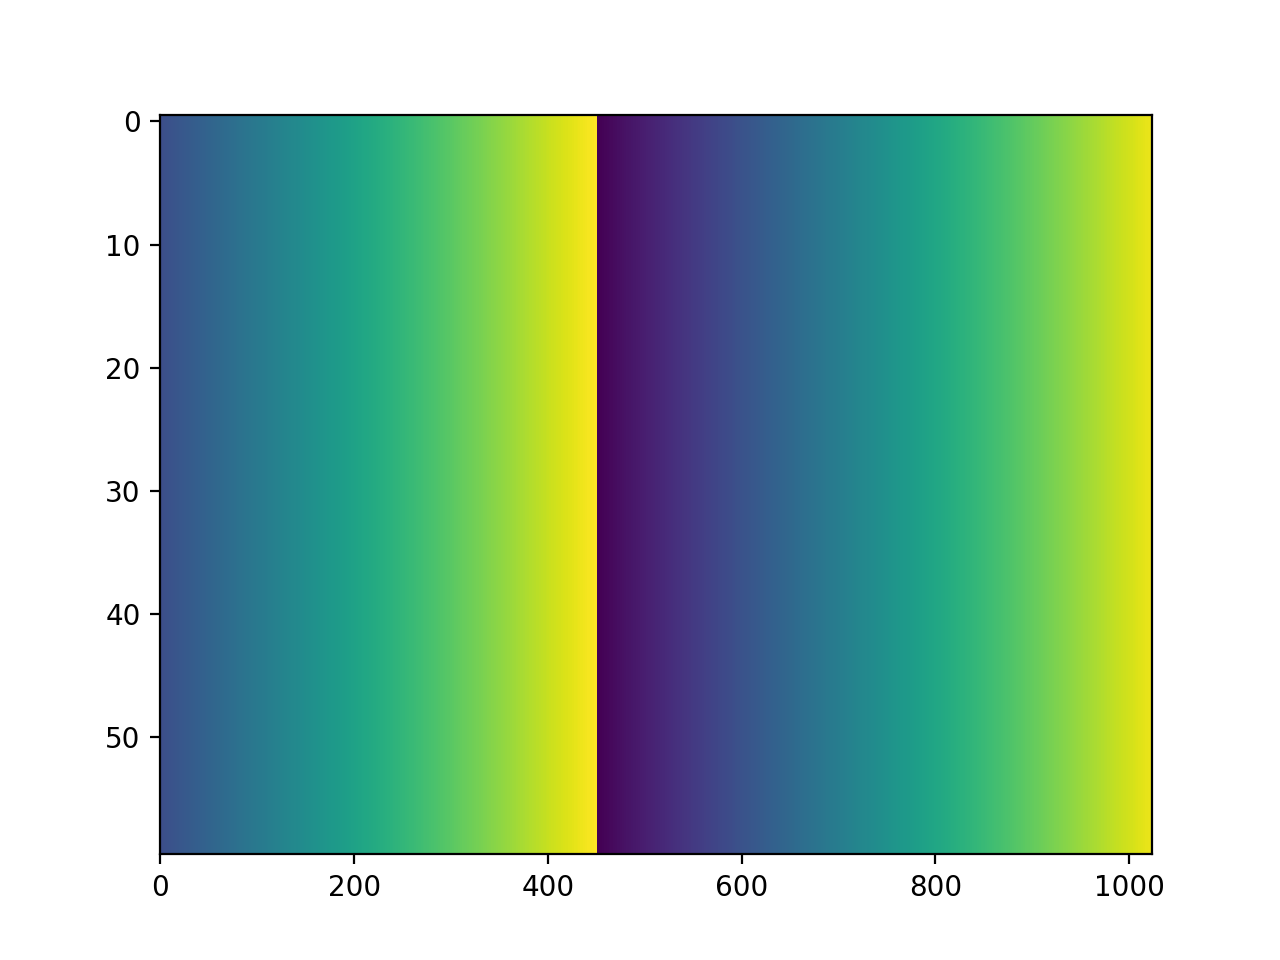

In [6]:
print AC.dly_slope_gain[0,'x'].shape
int0_delay_slope_gains = deepcopy(AC.custom_dly_slope_gain(total_gain_keys, total_data_antpos))
for k in int0_delay_slope_gains.keys():
    int0_delay_slope_gains[k][:,:] = int0_delay_slope_gains[k][0,:]
plt.figure()
plt.imshow(np.angle(AC.dly_slope_gain[0,'x']),aspect='auto')
plt.figure()
plt.imshow(np.angle(int0_delay_slope_gains[0,'x']),aspect='auto')

In [16]:
if delay_slope_cal:
    apply_cal.recalibrate_in_place(AC.data, AC.wgts, int0_delay_slope_gains, cal_flags, gain_convention='divide')
    if all_antenna_gains:
        merged_gains.append(int0_delay_slope_gains)
#     else:
#         merged_gains.append(AC.dly_slope_gain)
    merged_gains = [merge_gains(merged_gains)]

after_delay_slope_cal = deepcopy(merged_gains)
AC_after_delay_slope = deepcopy(AC)

In [17]:
if phase_slope_cal:
    if delay_slope_cal == False:
        echo("it is recommended to run a delay_slope_cal before phase_slope_cal", verbose=verbose)
    for i in range(phs_max_iter):
        AC.global_phase_slope_logcal(tol=tol, edge_cut=edge_cut, verbose=verbose)
        cal_flags = odict(map(lambda k: (k, np.zeros_like(AC.phs_slope_gain[k], np.bool)), AC.phs_slope_gain.keys()))
        apply_cal.recalibrate_in_place(AC.data, AC.wgts, AC.phs_slope_gain, cal_flags, gain_convention='divide')
        if all_antenna_gains:
            merged_gains.append(AC.custom_phs_slope_gain(total_gain_keys, total_data_antpos))
        else:
            merged_gains.append(AC.phs_slope_gain)
        # test for convergence
        if len(merged_gains) > 1:
            gains_before = merge_gains(merged_gains[:-1])
            gains_after = merge_gains(merged_gains)
            # take L2 norm over antennas and times
            gains_norm = np.linalg.norm([gains_after[k] for k in gains_after.keys()],axis=(0,1))
            delta_gains_norm = np.linalg.norm([gains_after[k] - gains_before[k] for k in gains_after.keys()],axis=(0,1))
            # take median over frequency to avoid the effect of band edges and RFI
            echo("phase_slope_cal convergence criterion: " + str(np.median(delta_gains_norm / gains_norm)), verbose=verbose)
            if np.median(delta_gains_norm / gains_norm) < phs_conv_crit:
                break        
        merged_gains = [merge_gains(merged_gains)]

after_phase_slope_cal = deepcopy(merged_gains)

...configuring linsolve data for global_phase_slope_logcal


invalid value encountered in divide


...running linsolve
...finished linsolve
phase_slope_cal convergence criterion: 0.891236772456
...configuring linsolve data for global_phase_slope_logcal
...running linsolve
...finished linsolve
phase_slope_cal convergence criterion: 0.280343126596
...configuring linsolve data for global_phase_slope_logcal
...running linsolve
...finished linsolve
phase_slope_cal convergence criterion: 0.0190527348263
...configuring linsolve data for global_phase_slope_logcal
...running linsolve
...finished linsolve
phase_slope_cal convergence criterion: 0.00123368384563
...configuring linsolve data for global_phase_slope_logcal
...running linsolve
...finished linsolve
phase_slope_cal convergence criterion: 0.000131354595466


In [18]:
if abs_amp_cal:
    AC.abs_amp_logcal(verbose=verbose)
    cal_flags = odict(map(lambda k: (k, np.zeros_like(AC.abs_eta_gain[k], np.bool)), AC.abs_eta_gain.keys()))
    apply_cal.recalibrate_in_place(AC.data, AC.wgts, AC.abs_eta_gain, cal_flags, gain_convention='divide')
    if all_antenna_gains:
        merged_gains.append(AC.custom_abs_eta_gain(total_gain_keys))
    else:
        merged_gains.append(AC.abs_eta_gain)
    merged_gains = [merge_gains(merged_gains)]

after_abs_amp_cal = deepcopy(merged_gains)    

...configuring linsolve data for abs_amp_logcal


divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in log


...running linsolve
...finished linsolve


In [19]:
if TT_phs_cal:
    if delay_slope_cal == False or phase_slope_cal == False:
        echo("it is recommended to run a delay_slope_cal and a phase_slope_cal before TT_phs_cal", verbose=verbose)
    for i in range(phs_max_iter):
        AC.TT_phs_logcal(verbose=verbose)
        cal_flags = odict(map(lambda k: (k, np.zeros_like(AC.TT_Phi_gain[k], np.bool)), AC.TT_Phi_gain.keys()))
        apply_cal.recalibrate_in_place(AC.data, AC.wgts, AC.TT_Phi_gain, cal_flags, gain_convention='divide')
        if all_antenna_gains:
            merged_gains.append(AC.custom_TT_Phi_gain(total_gain_keys, total_data_antpos))
            merged_gains.append(AC.custom_abs_psi_gain(total_gain_keys))
        else:
            merged_gains.append(AC.abs_psi_gain)
            merged_gains.append(AC.TT_Phi_gain)
        # test for convergence
        if len(merged_gains) > 2:
            gains_before = merge_gains(merged_gains[:-2])
            gains_after = merge_gains(merged_gains)
            # take L2 norm over antennas and times
            gains_norm = np.linalg.norm([gains_after[k] for k in gains_after.keys()],axis=(0,1))
            delta_gains_norm = np.linalg.norm([gains_after[k] - gains_before[k] for k in gains_after.keys()],axis=(0,1))
            # take median over frequency to avoid the effect of band edges and RFI
            echo("TT_phs_cal convergence criterion: " + str(np.median(delta_gains_norm / gains_norm)), verbose=verbose)
            if np.median(delta_gains_norm / gains_norm) < phs_conv_crit:
                break
        merged_gains = [merge_gains(merged_gains)]

after_TT_phs_cal = deepcopy(merged_gains)

...configuring linsolve data for TT_phs_logcal


divide by zero encountered in divide
invalid value encountered in divide


...running linsolve
...finished linsolve
TT_phs_cal convergence criterion: 0.114486418221
...configuring linsolve data for TT_phs_logcal
...running linsolve
...finished linsolve
TT_phs_cal convergence criterion: 0.0370207136335
...configuring linsolve data for TT_phs_logcal
...running linsolve
...finished linsolve
TT_phs_cal convergence criterion: 0.0139487223382
...configuring linsolve data for TT_phs_logcal
...running linsolve
...finished linsolve
TT_phs_cal convergence criterion: 0.00675063394707
...configuring linsolve data for TT_phs_logcal
...running linsolve
...finished linsolve
TT_phs_cal convergence criterion: 0.00329868272078


In [20]:

# collate gains
if len(merged_gains) == 0:
    raise ValueError("abscal_run executed without any calibration arguments set to True")
gain_dict = merge_gains(merged_gains)
flag_dict = odict(map(lambda k: (k, np.zeros((Ntimes, Nfreqs), np.bool)), gain_dict.keys()))
gain_pols = AC.gain_pols
gain_keys = gain_dict.keys()

# make extra calfits metadata
total_qual = odict(map(lambda p: (p, np.ones((Ntimes, Nfreqs), np.float)), gain_pols))
quals = odict(map(lambda k: (k, np.ones((Ntimes, Nfreqs), np.float)), gain_keys))

# load in extra calfits file if provided
if calfits_infile is not None:
    cal_in = UVCal()
    cal_in.read_calfits(calfits_infile)
    (out_gains, out_flags, quals, total_qual, ants, freqs, times, 
     pols) = io.load_cal(cal_in, return_meta=True)
    history = cal_in.history + history

# construct merged gains
new_gains = odict()
new_flags = odict()
for k in out_gains.keys():
    if k in gain_dict:
        new_gains[k] = out_gains[k] * gain_dict[k]
        new_flags[k] = out_flags[k] + flag_dict[k]
    else:
        new_flags[k] = out_flags[k] + np.ones_like(out_flags[k], np.bool)
gain_dict = new_gains
flag_dict = new_flags

# ensure reference antenna phase has been projected out (i.e. set to zero)
for p in gain_pols:
    refant_phasor = gain_dict[(refant, p)] / np.abs(gain_dict[(refant, p)])
for k in gain_dict.keys(): 
    if p in k:
        gain_dict[k] /= refant_phasor

if write_calfits:
    io.write_cal(output_calfits_path, gain_dict, data_freqs, data_times, flags=flag_dict, quality=quals, 
                 total_qual=total_qual, return_uvc=False, overwrite=overwrite, history=history)

saving ././interactive.abs.calfits


# Investigate results

In [21]:
ogains, oflags = hc.io.load_cal('zen.2458101.65493.xx.HH.uv.omni.calfits')

In [22]:
flagged_bls = [bl for bl in data_flags.keys() if np.all(data_flags[bl])]
reds = hc.redcal.get_reds(data_antpos, pols=['xx'])
reds = [[bl for bl in red if bl not in flagged_bls] for red in reds]
reds = [red for red in reds if len(red) > 0]
blvecs = np.array([data_antpos[red[0][1]] - data_antpos[red[0][0]] for red in reds if red[0][2] == 'xx'])

In [23]:
def bl_avg_data(data, reds, pol):
    avg_data = []
    for red in reds:
        if red[0][2] == pol:
            avg_data.append(np.mean([data[bl] for bl in red], axis=0))
    return np.array(avg_data)

In [24]:
after_delay_slope_data = DataContainer({bl: data[bl] / after_delay_slope_cal[0][bl[0],bl[2][0]] / 
                                   np.conj(after_delay_slope_cal[0][bl[1],bl[2][1]]) for bl in data.keys()})
after_phase_slope_data = DataContainer({bl: data[bl] / after_phase_slope_cal[0][bl[0],bl[2][0]] / 
                                   np.conj(after_phase_slope_cal[0][bl[1],bl[2][1]]) for bl in data.keys()})

In [25]:
avg_after_delay_slope_data = bl_avg_data(after_delay_slope_data, reds, 'xx')
avg_after_phase_slope_data = bl_avg_data(after_phase_slope_data, reds, 'xx')
avg_model = bl_avg_data(new_model, reds, 'xx')

<IPython.core.display.Javascript object>


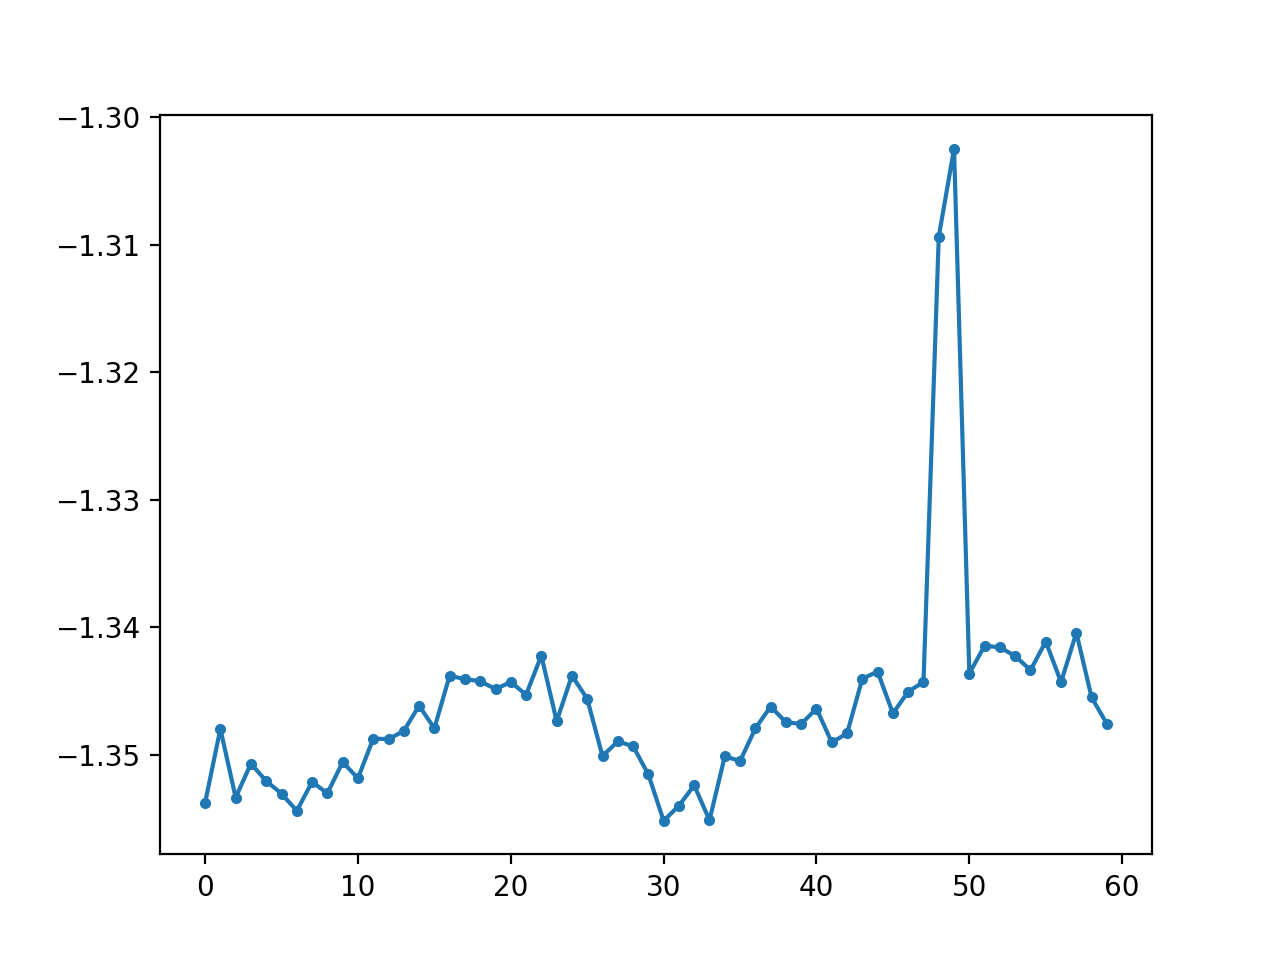

In [27]:
plt.figure()
ant = (52,'x')
plt.plot(np.angle((ogains[ant]*after_phase_slope_cal[0][ant])[:,1]),'.-')

In [31]:
fit = global_phase_slope_logcal(AC_after_delay_slope.model, AC_after_delay_slope.data, AC_after_delay_slope.antpos,
                               wgts=AC_after_delay_slope.wgts, refant=refant, verbose=verbose, tol=tol)

...configuring linsolve data for global_phase_slope_logcal
...running linsolve
...finished linsolve


In [28]:
# nflagged = 0
# for k in AC_after_delay_slope.wgts.keys():
# #     print k, np.all(AC_after_delay_slope.wgts[k]==0)
#     if np.all(AC_after_delay_slope.wgts[k]==0): nflagged += 1
# print nflagged
# print len(AC_after_delay_slope.wgts.keys())

In [29]:
# nflagged = 0
# for k in avg_wgts.keys():
#     if np.all(avg_wgts[k]==0): nflagged += 1
# print nflagged
# print len(avg_wgts.keys())

<IPython.core.display.Javascript object>


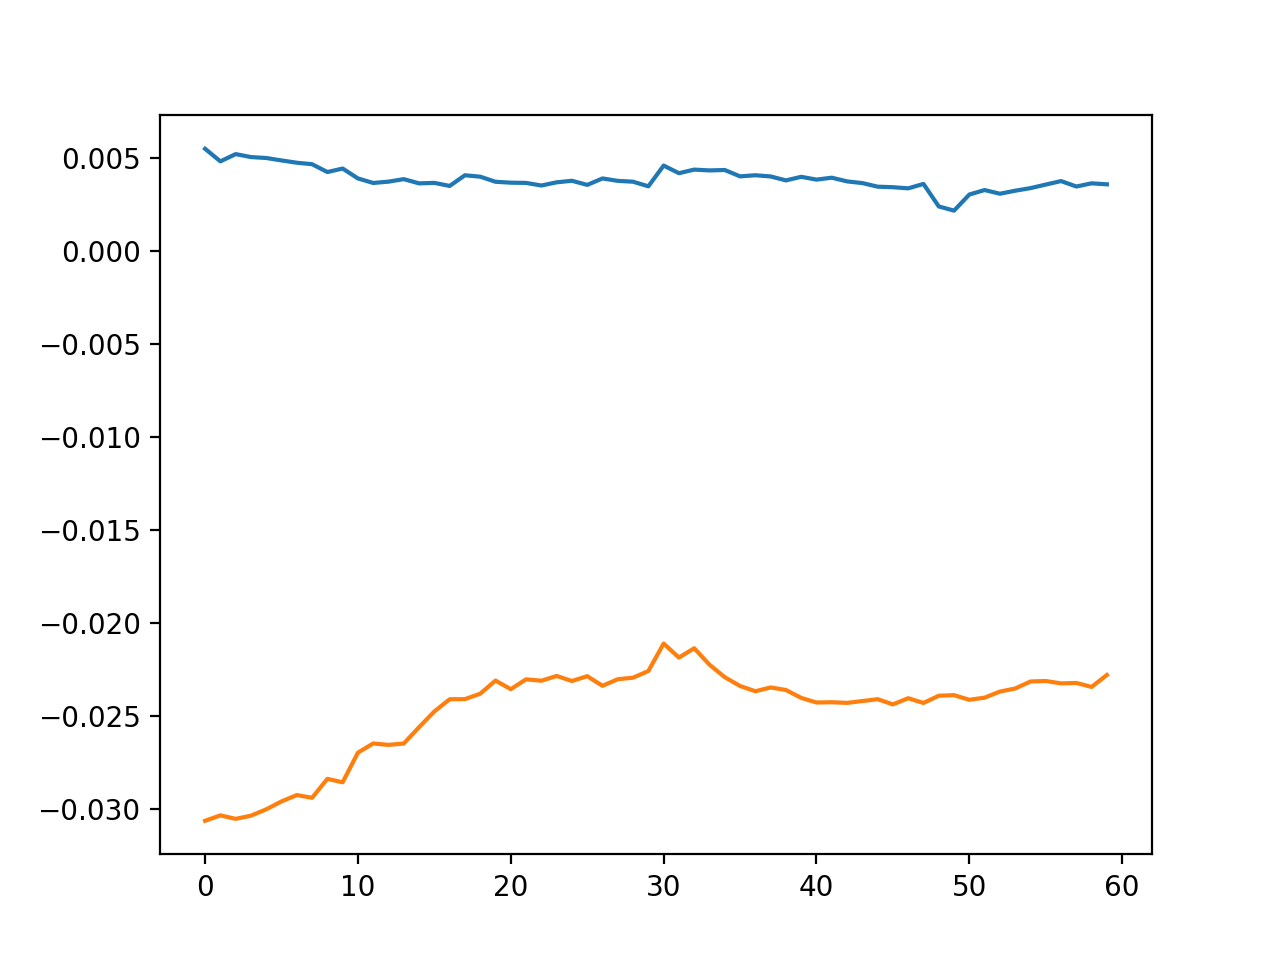

In [32]:
plt.figure()
plt.plot(fit['Phi_ew_x'])
plt.plot(fit['Phi_ns_x'])

<IPython.core.display.Javascript object>


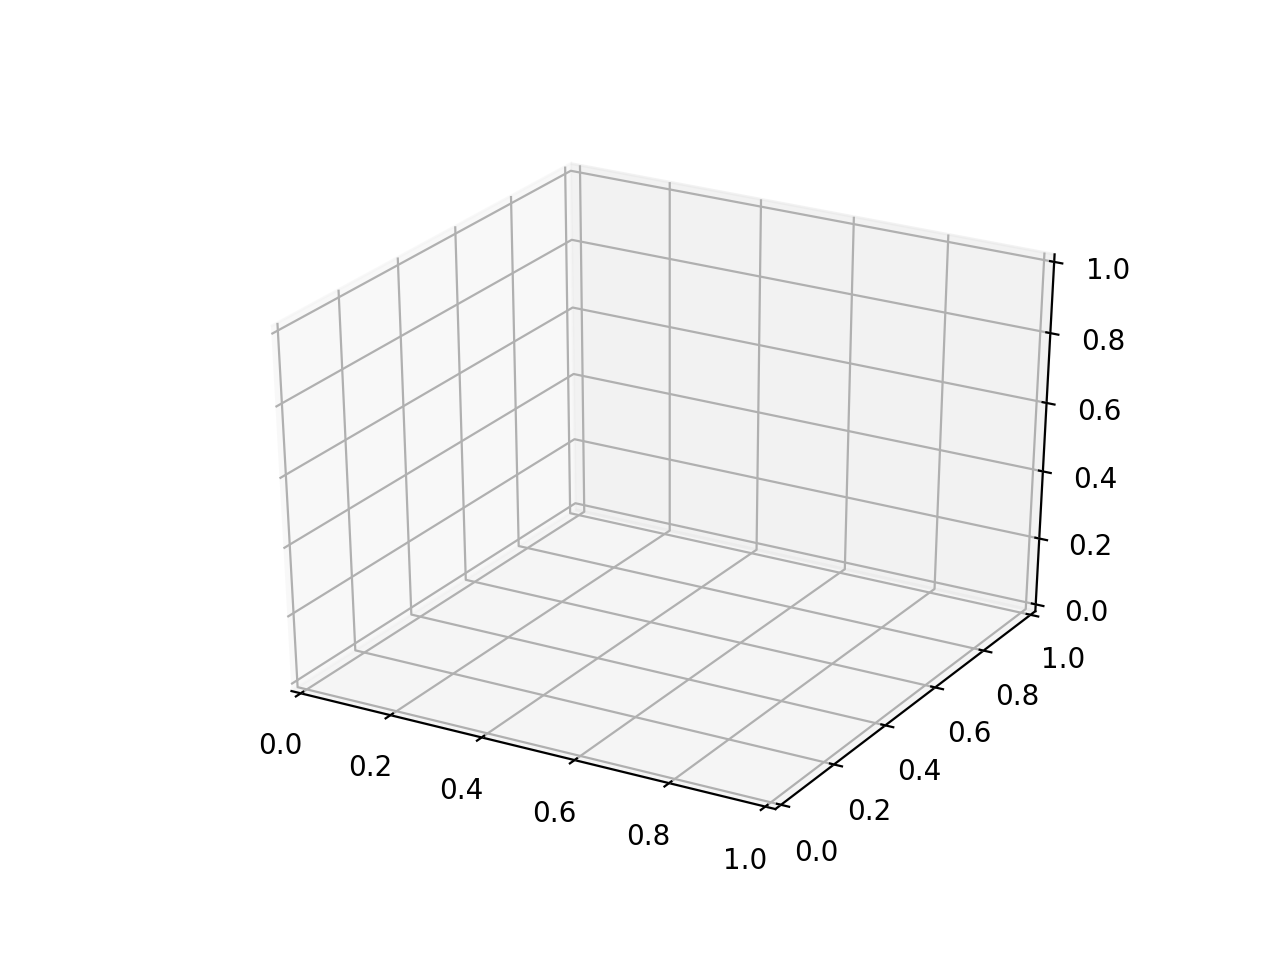

NameError: name 'blvecs' is not defined

In [12]:
integration = 30
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter3D(blvecs[:,0], blvecs[:,1],np.nanmedian(np.angle(avg_after_delay_slope_data / avg_model), axis=2)[:,integration], label='Full OmniAbs')
#ax.scatter3D(blvecs[:,0], blvecs[:,1], 
#             (np.pi + -blvecs[:,0]*fit['Phi_ew_x'][integration] - blvecs[:,1]*fit['Phi_ns_x'][integration]) % (2 * np.pi ) - np.pi)
ax.scatter3D(blvecs[:,0], blvecs[:,1], 
             -blvecs[:,0]*fit['Phi_ew_x'][integration] - blvecs[:,1]*fit['Phi_ns_x'][integration])

<IPython.core.display.Javascript object>


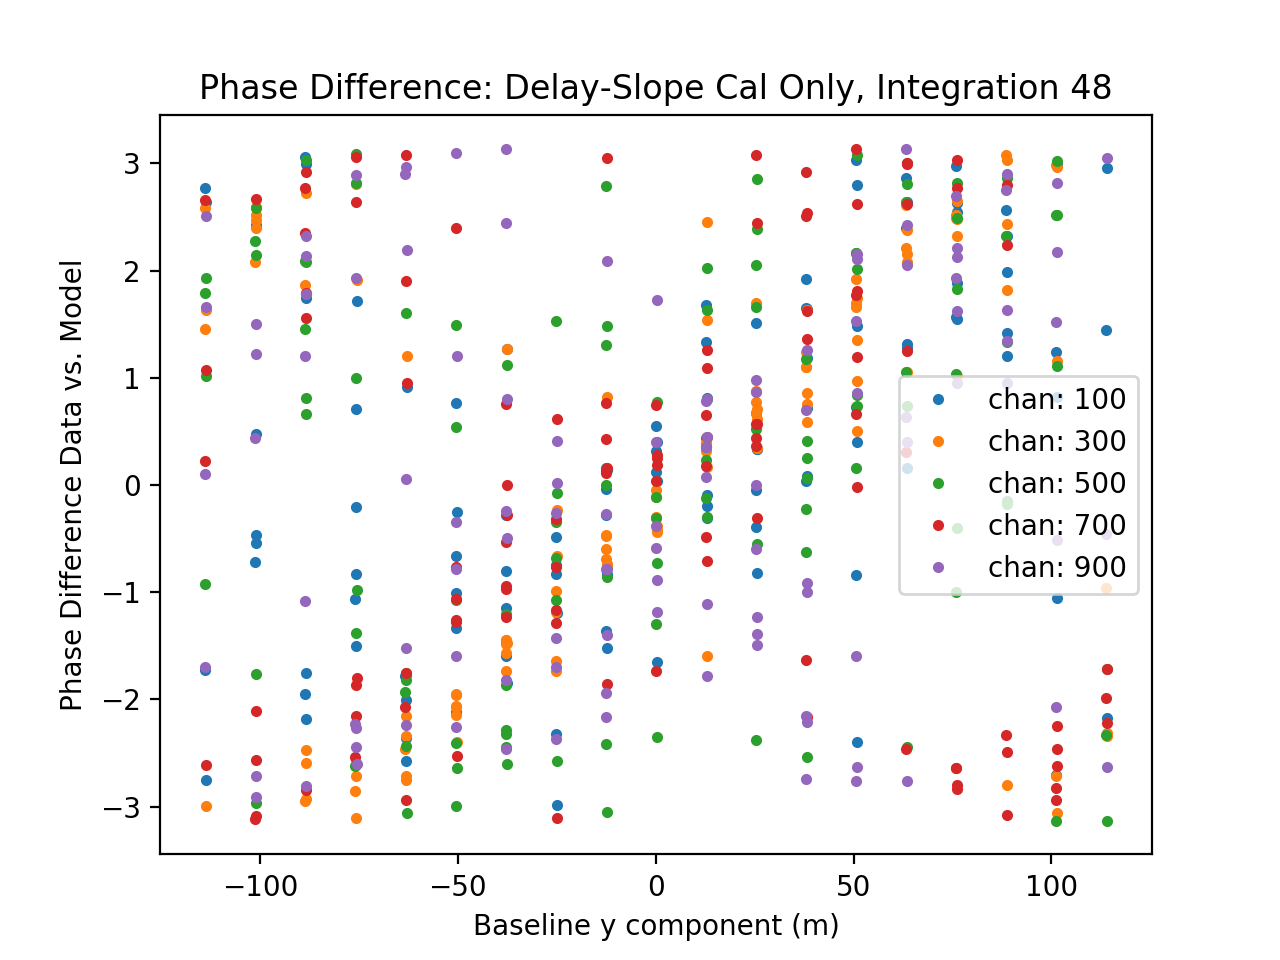

divide by zero encountered in divide


Text(0.5,1,u'Phase Difference: Delay-Slope Cal Only, Integration 48')

In [35]:
integration = 48

plt.figure()
for chan in [100,300,500,700,900]:
    plt.plot(blvecs[:,1], np.angle(np.mean(avg_after_delay_slope_data[:,integration:integration+1,chan] / avg_model[:,integration:integration+1,chan],axis=1)),
             '.', label='chan: '+str(chan))
plt.legend()
plt.xlabel('Baseline y component (m)')
plt.ylabel('Phase Difference Data vs. Model')
plt.title('Phase Difference: Delay-Slope Cal Only, Integration '+str(integration))

<IPython.core.display.Javascript object>


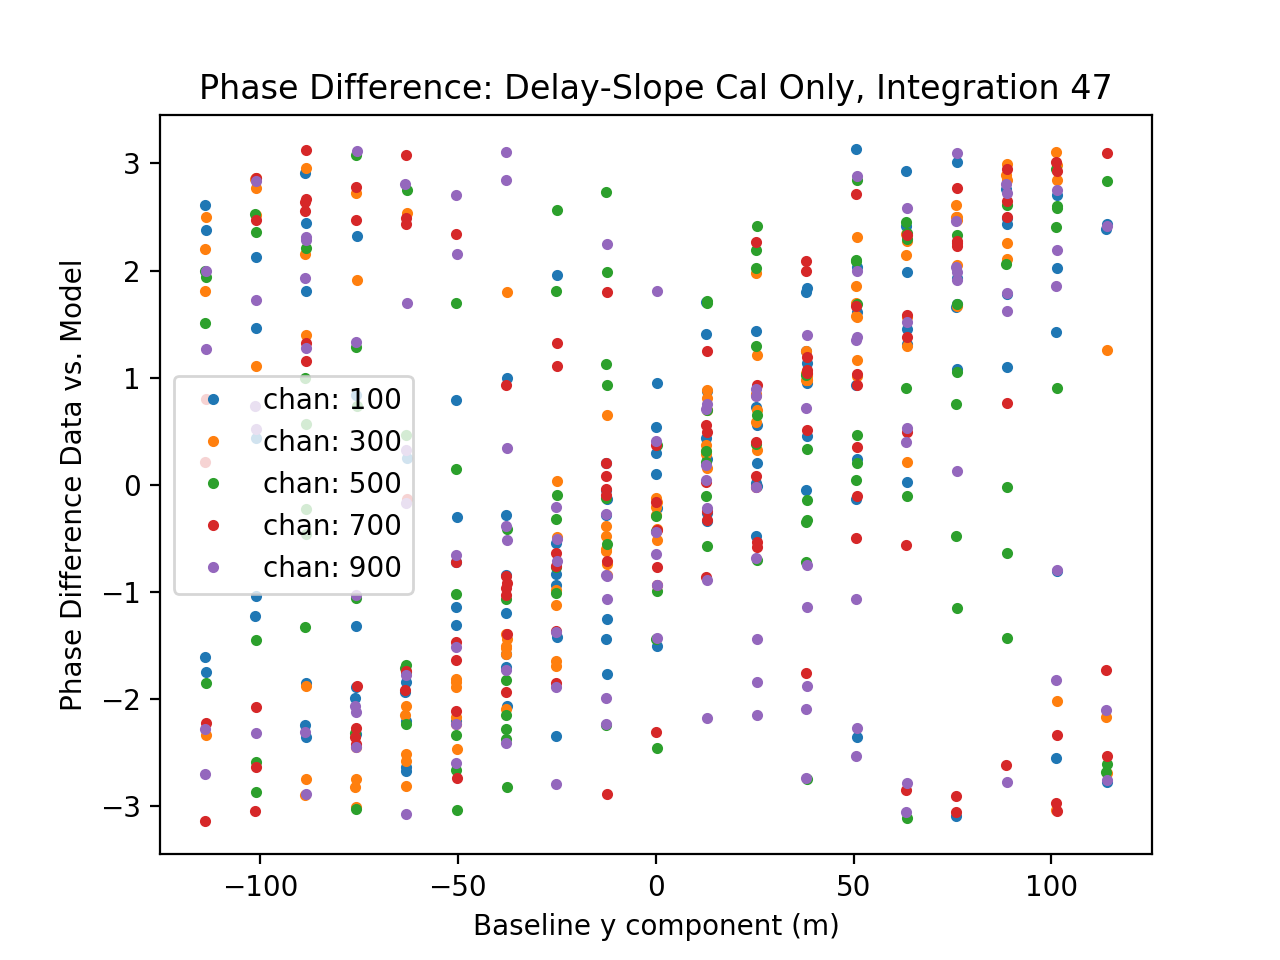

divide by zero encountered in divide


Text(0.5,1,u'Phase Difference: Delay-Slope Cal Only, Integration 47')

In [38]:
integration=47
plt.figure()
for chan in [100,300,500,700,900]:
    plt.plot(blvecs[:,1], np.angle(np.mean(avg_after_delay_slope_data[:,integration:integration+1,chan] / avg_model[:,integration:integration+1,chan],axis=1)),
             '.', label='chan: '+str(chan))
plt.legend()
plt.xlabel('Baseline y component (m)')
plt.ylabel('Phase Difference Data vs. Model')
plt.title('Phase Difference: Delay-Slope Cal Only, Integration '+str(integration))

<IPython.core.display.Javascript object>


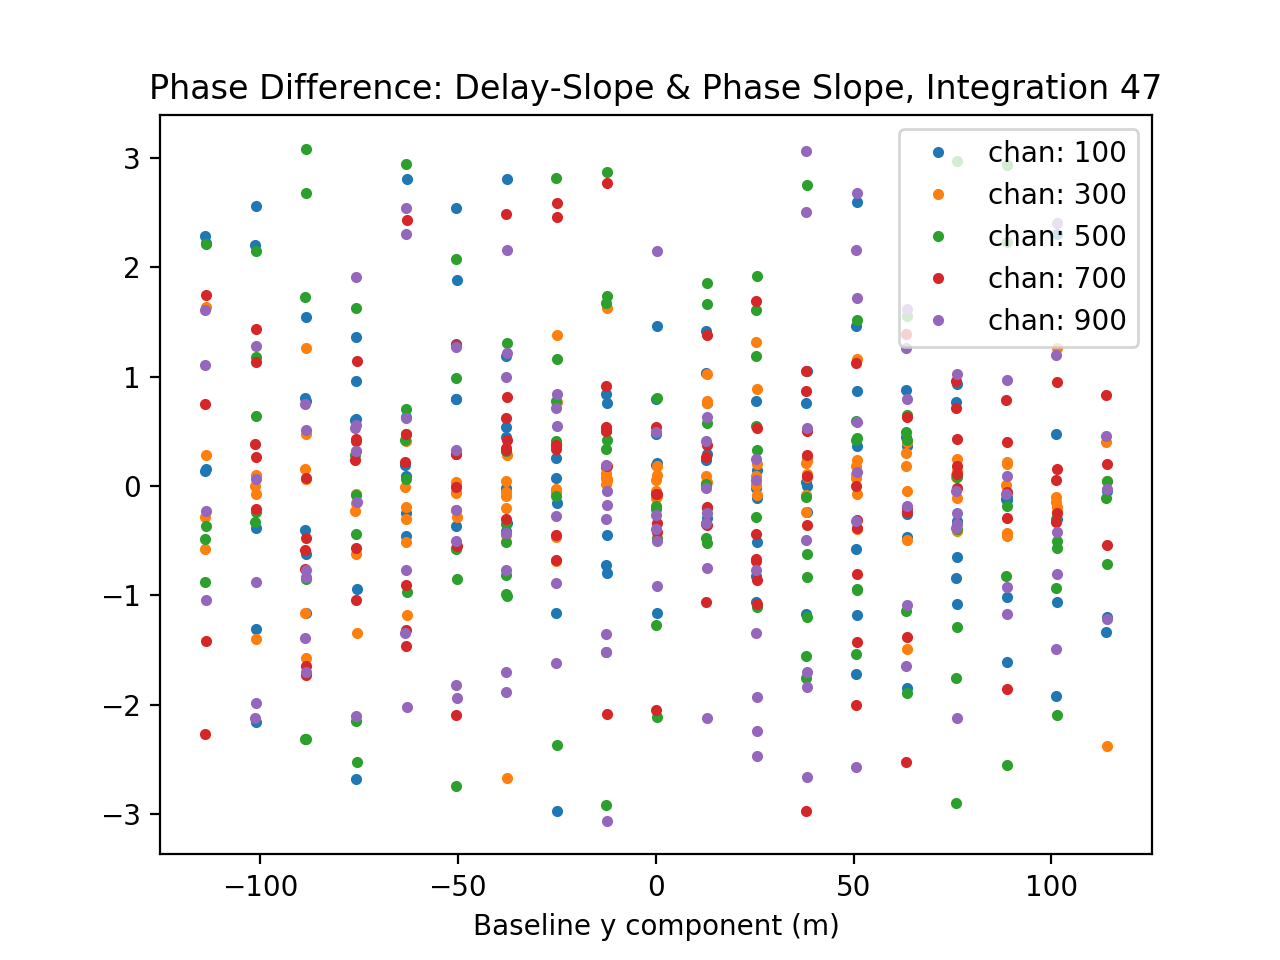

divide by zero encountered in divide


Text(0.5,1,u'Phase Difference: Delay-Slope & Phase Slope, Integration 47')

In [39]:
integration = 47
plt.figure()
for chan in [100,300,500,700,900]:
    plt.plot(blvecs[:,1], np.angle(np.mean(avg_after_phase_slope_data[:,integration:integration+1,chan] / avg_model[:,integration:integration+1,chan],axis=1)),
             '.', label='chan: '+str(chan))
plt.legend()
plt.xlabel('Baseline y component (m)')
plt.title('Phase Difference: Delay-Slope & Phase Slope, Integration '+str(integration))

<IPython.core.display.Javascript object>


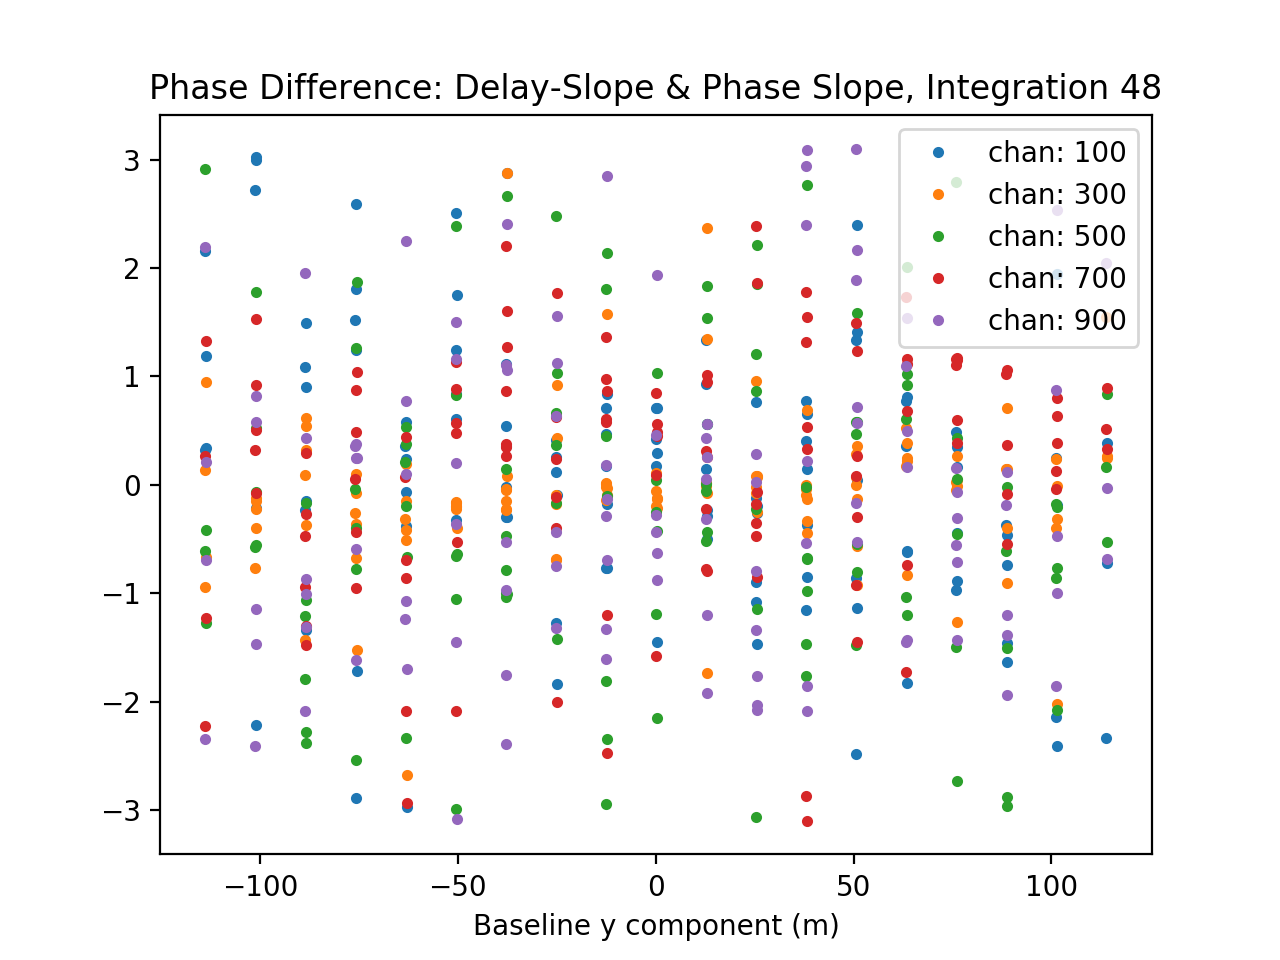

divide by zero encountered in divide


Text(0.5,1,u'Phase Difference: Delay-Slope & Phase Slope, Integration 48')

In [40]:
integration = 48
plt.figure()
for chan in [100,300,500,700,900]:
    plt.plot(blvecs[:,1], np.angle(np.mean(avg_after_phase_slope_data[:,integration:integration+1,chan] / avg_model[:,integration:integration+1,chan],axis=1)),
             '.', label='chan: '+str(chan))
plt.legend()
plt.xlabel('Baseline y component (m)')
plt.title('Phase Difference: Delay-Slope & Phase Slope, Integration '+str(integration))

<IPython.core.display.Javascript object>


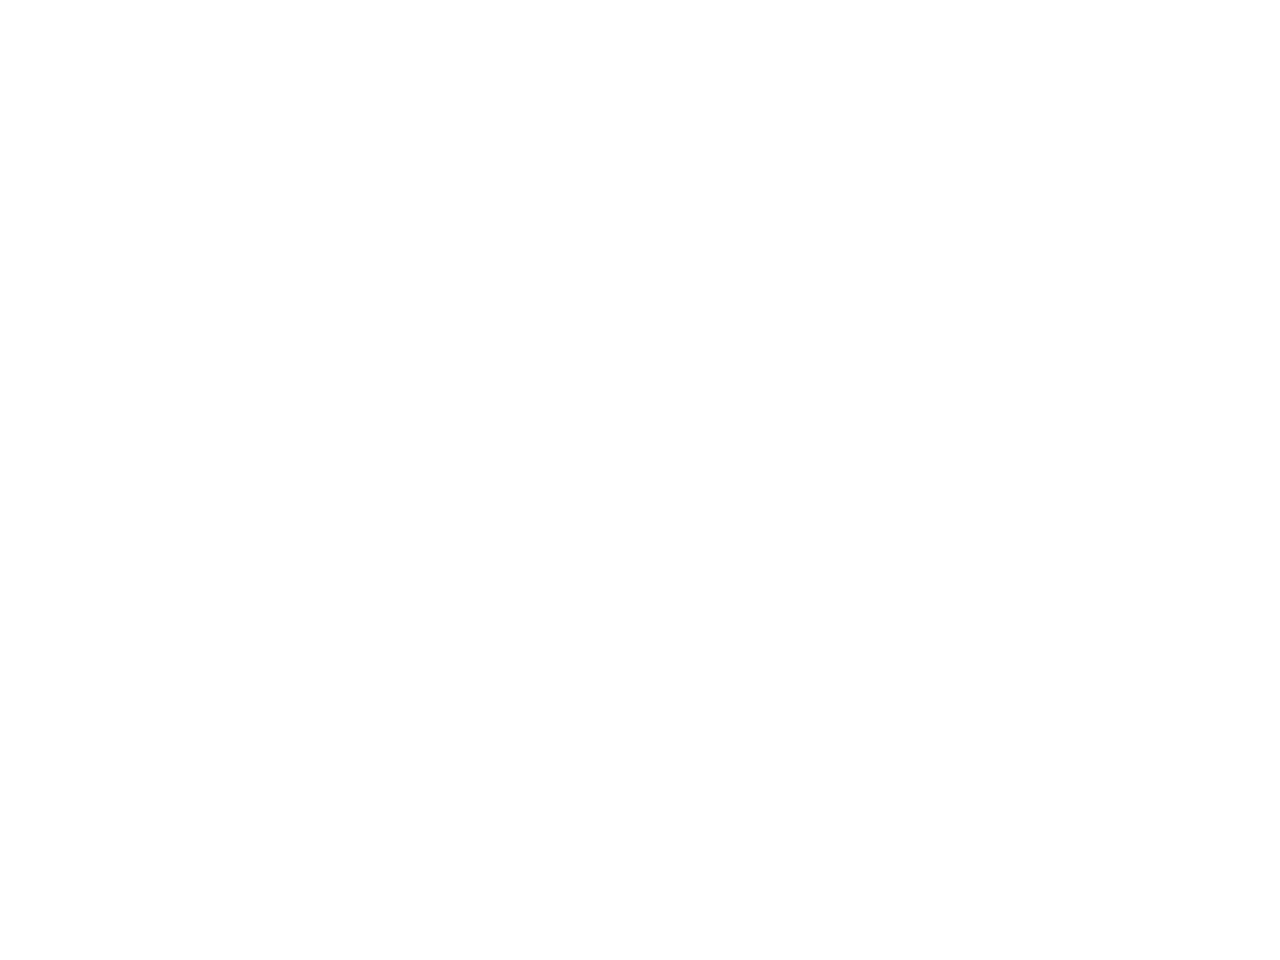

NameError: name 'after_avg_dly_slope_cal' is not defined

In [42]:
ant = (52,'x')
plt.figure()
plt.imshow(np.angle(ogains[ant]*after_avg_dly_slope_cal[0][ant]), aspect='auto')
plt.colorbar()
plt.title('Omnical + Abscal up through avg delay slope cal')


<IPython.core.display.Javascript object>


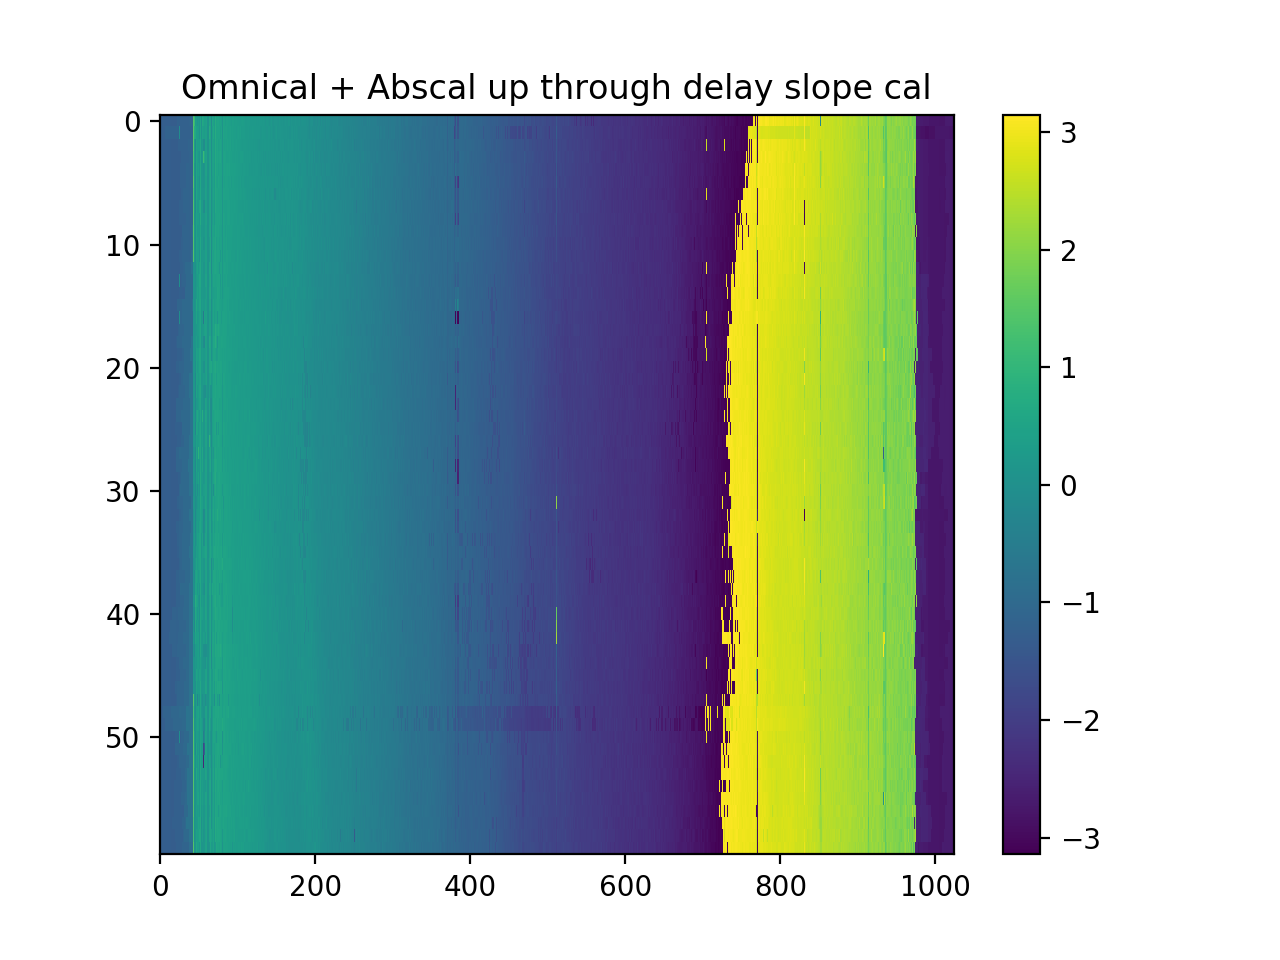

Text(0.5,1,u'Omnical + Abscal up through delay slope cal')

In [43]:
ant = (52,'x')
plt.figure()
plt.imshow(np.angle(ogains[ant]*after_delay_slope_cal[0][ant]), aspect='auto')
plt.colorbar()
plt.title('Omnical + Abscal up through delay slope cal')

In [44]:
gains, flags = hc.io.load_cal('zen.2458101.65493.xx.HH.uv.abs.calfits')

<IPython.core.display.Javascript object>


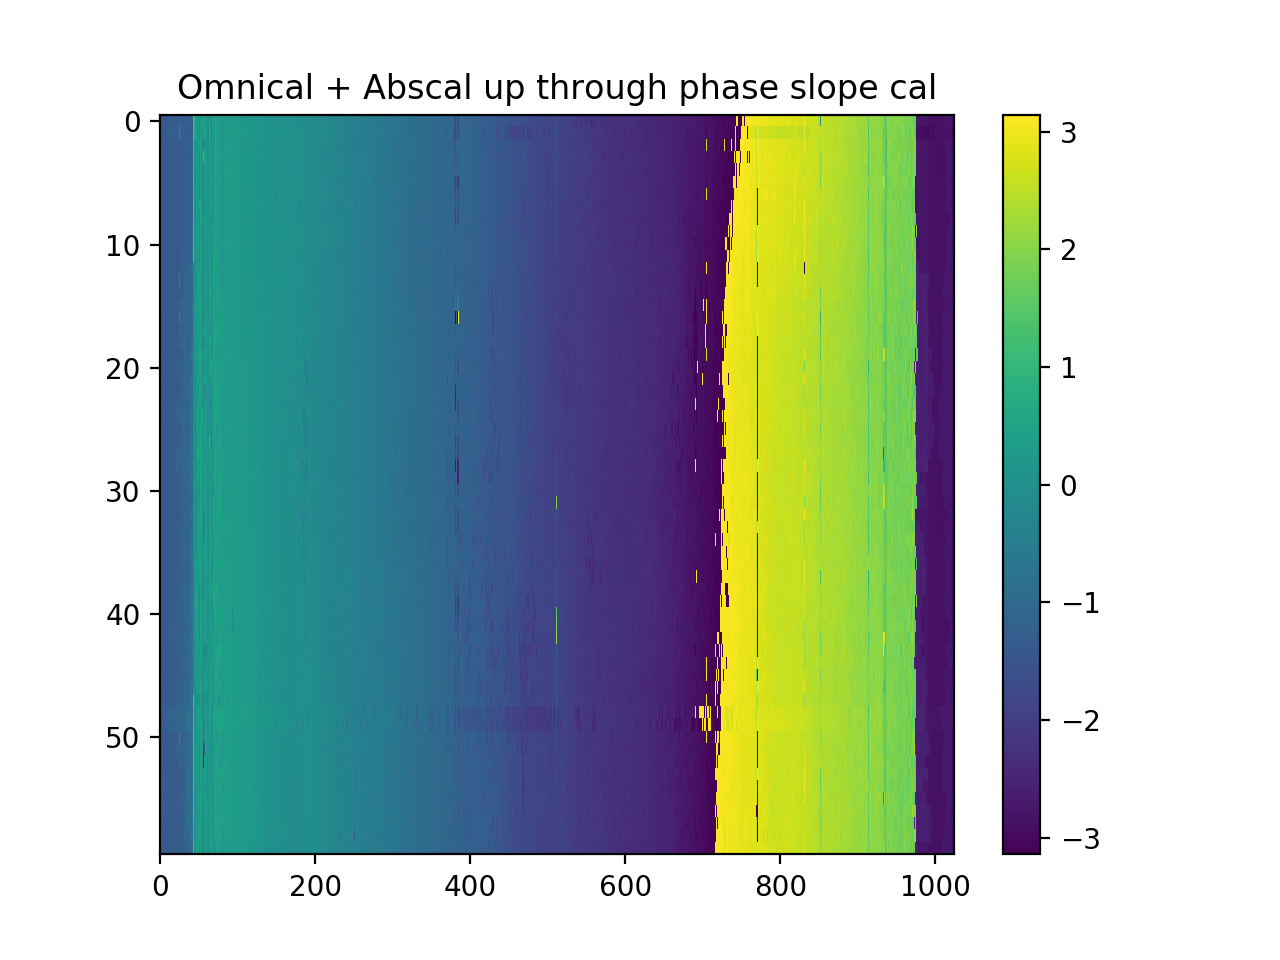

Text(0.5,1,u'Omnical + Abscal up through phase slope cal')

In [45]:
ant = (52,'x')
plt.figure()
plt.imshow(np.angle(ogains[ant]*after_phase_slope_cal[0][ant])*(1.0 / ~flags[ant]), aspect='auto')
plt.colorbar()
plt.title('Omnical + Abscal up through phase slope cal')

<IPython.core.display.Javascript object>


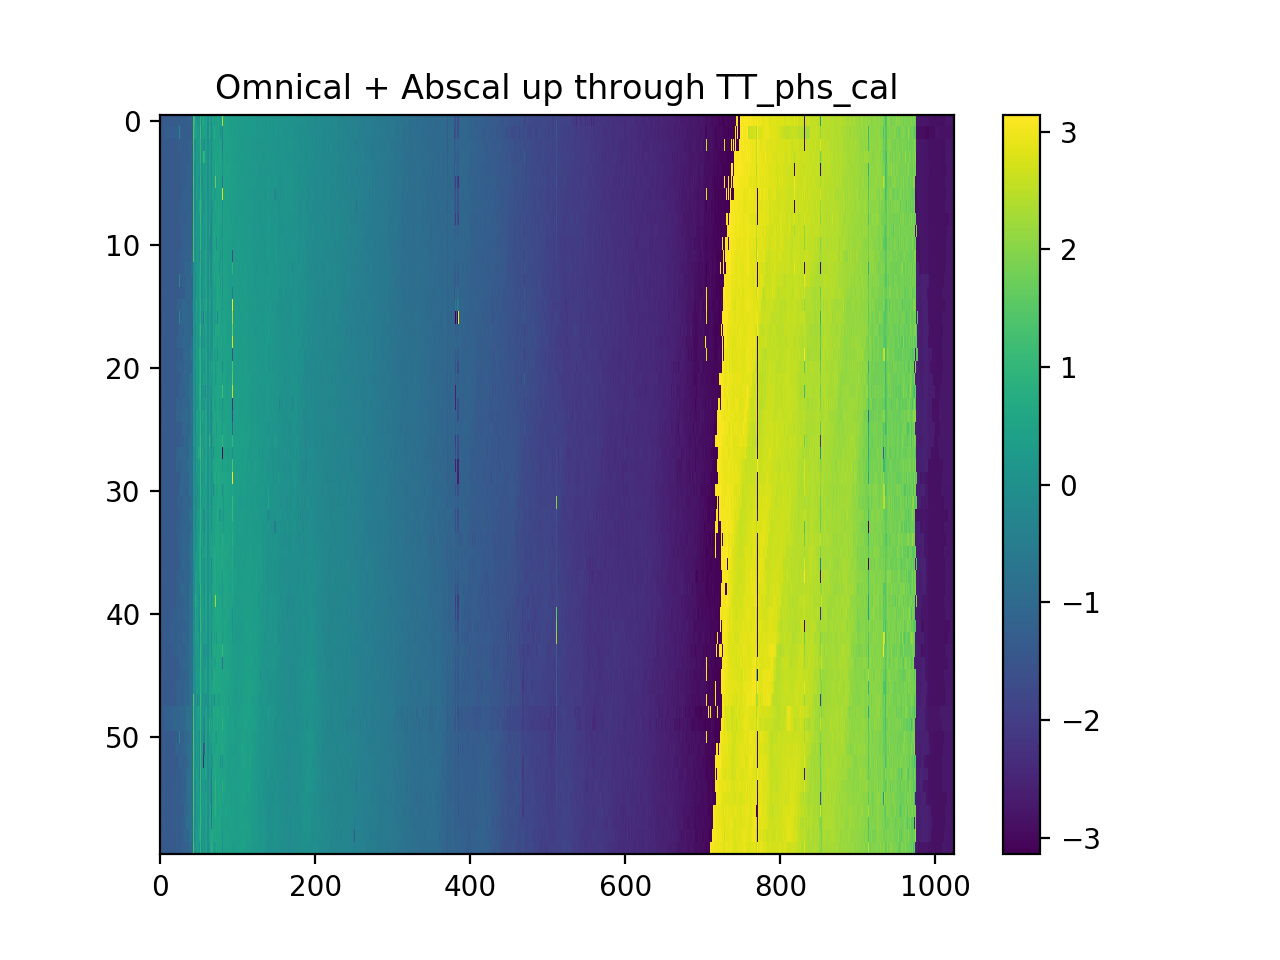

Text(0.5,1,u'Omnical + Abscal up through TT_phs_cal')

In [46]:
ant = (52,'x')
plt.figure()
plt.imshow(np.angle(ogains[ant]*after_TT_phs_cal[0][ant])*(1.0 / ~flags[ant]), aspect='auto')
plt.colorbar()
plt.title('Omnical + Abscal up through TT_phs_cal')

<IPython.core.display.Javascript object>


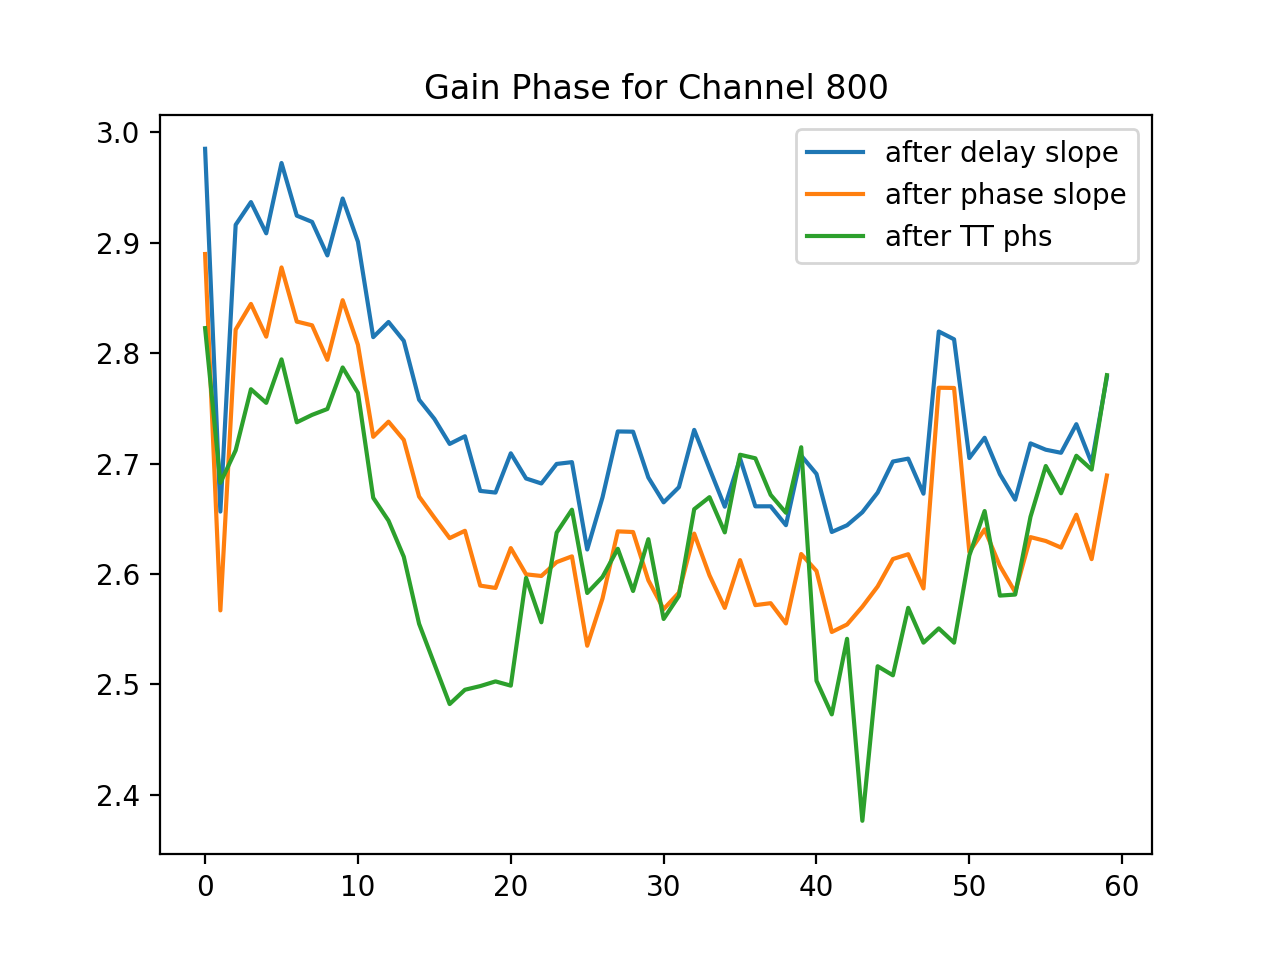

In [47]:
ant = (52,'x')
plt.figure()
plt.plot((np.angle(ogains[ant]*after_delay_slope_cal[0][ant])*(1.0 / ~flags[ant]))[:,800], label='after delay slope')
plt.plot((np.angle(ogains[ant]*after_phase_slope_cal[0][ant])*(1.0 / ~flags[ant]))[:,800], label='after phase slope')
plt.plot((np.angle(ogains[ant]*after_TT_phs_cal[0][ant])*(1.0 / ~flags[ant]))[:,800], label='after TT phs')
plt.title('Gain Phase for Channel 800')
plt.legend()
#plt.title('Omnical + Abscal up through phase slope cal')

In [48]:
gains.values()[0].shape[1]

1024

In [49]:
gains, flags = hc.io.load_cal('zen.2458101.65493.xx.HH.uv.abs.calfits')

<IPython.core.display.Javascript object>


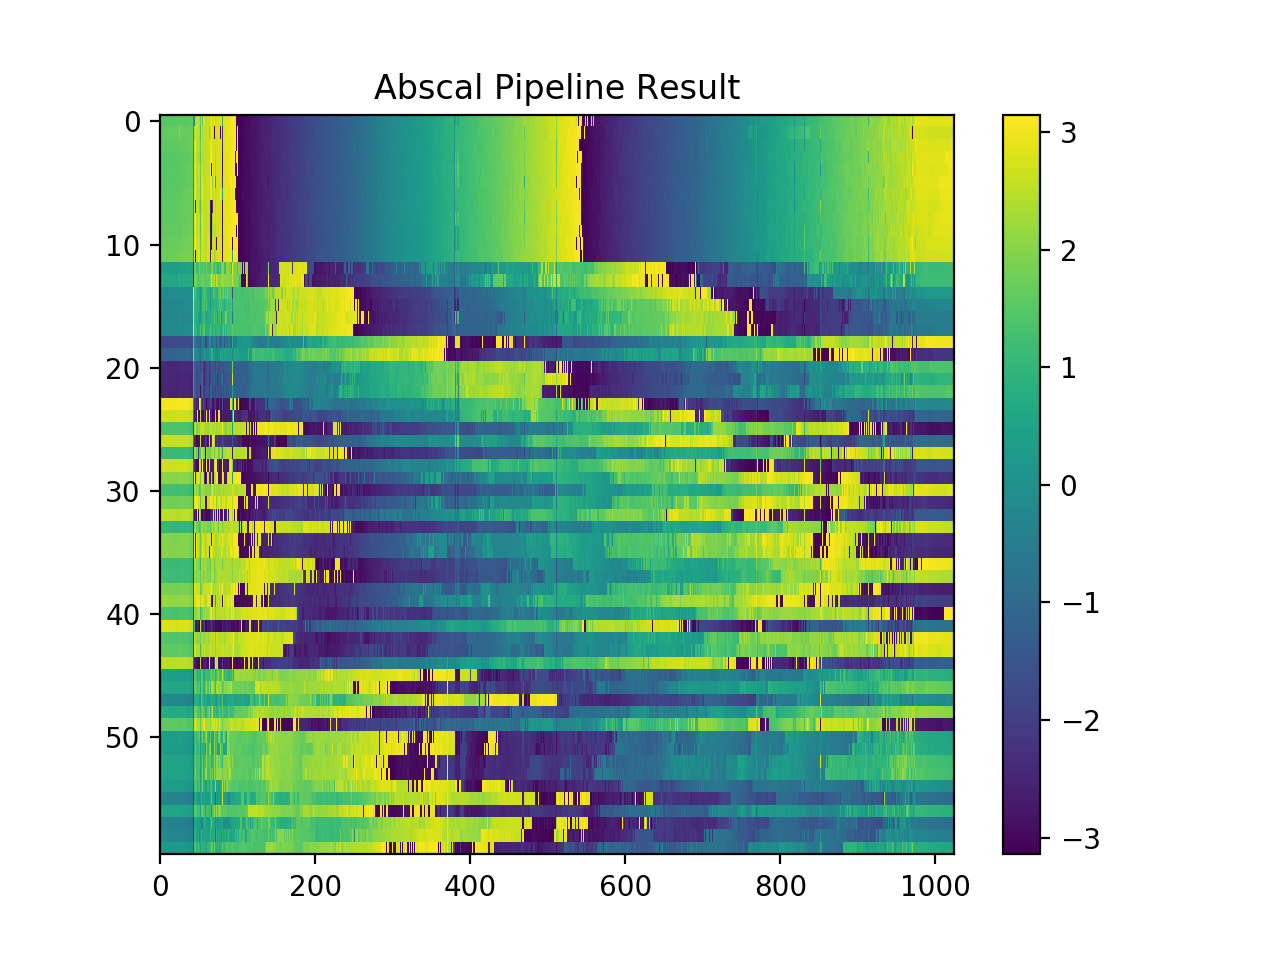

Text(0.5,1,u'Abscal Pipeline Result')

In [50]:
ant = (54,'x')
plt.figure()
plt.imshow(np.angle(gains[ant])*(1.0 / ~flags[ant]), aspect='auto')
plt.colorbar()
plt.title('Abscal Pipeline Result')

In [79]:
gains2, flags2 = io.load_cal('interactive.abs.calfits')

<IPython.core.display.Javascript object>


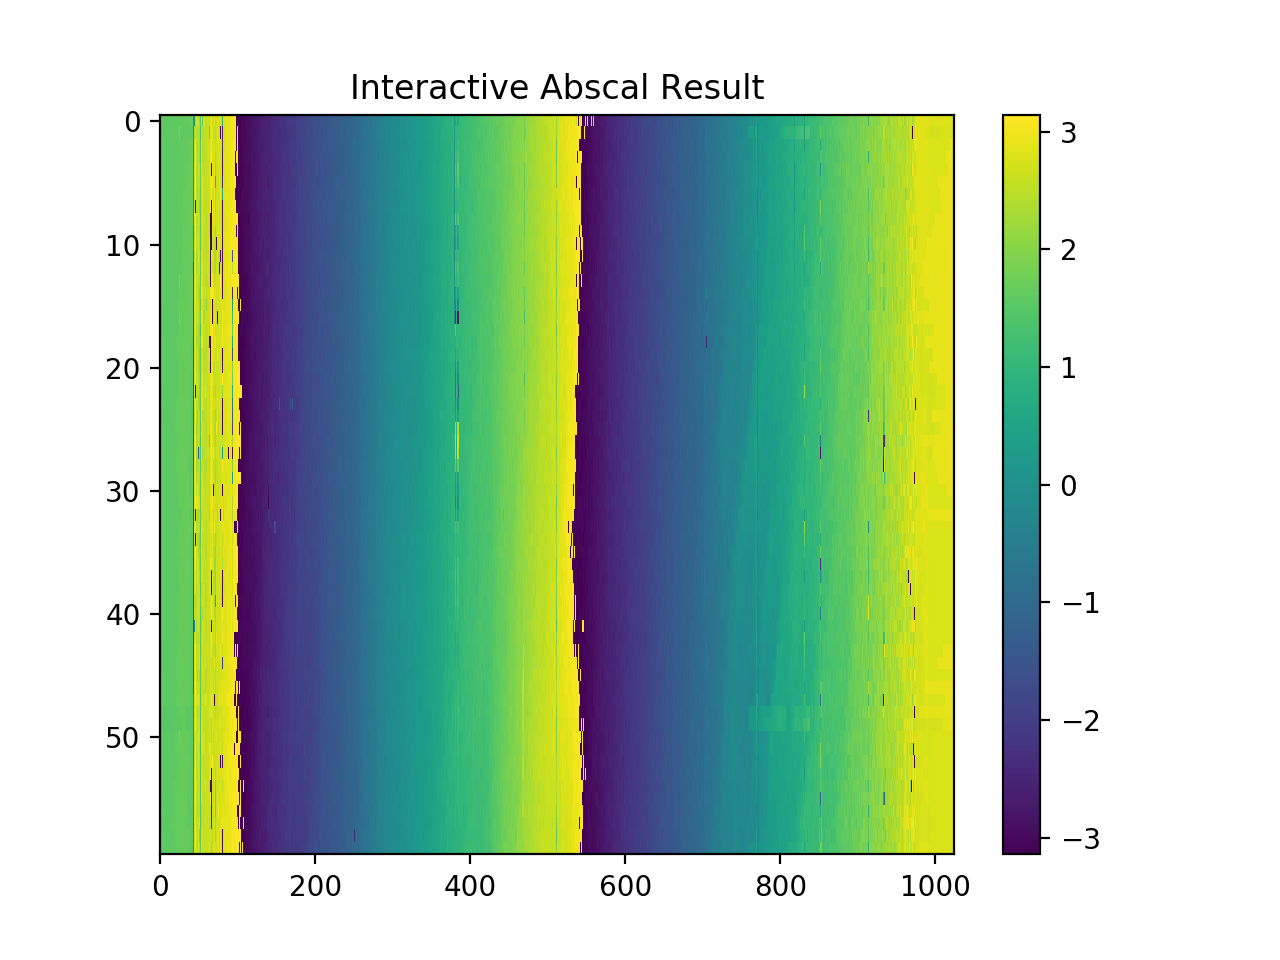

Text(0.5,1,u'Interactive Abscal Result')

In [164]:
ant = (54,'x')
plt.figure()
plt.imshow(np.angle(gains2[ant])*(1.0 / ~flags2[ant]), aspect='auto')
plt.colorbar()
plt.title('Interactive Abscal Result')

<IPython.core.display.Javascript object>


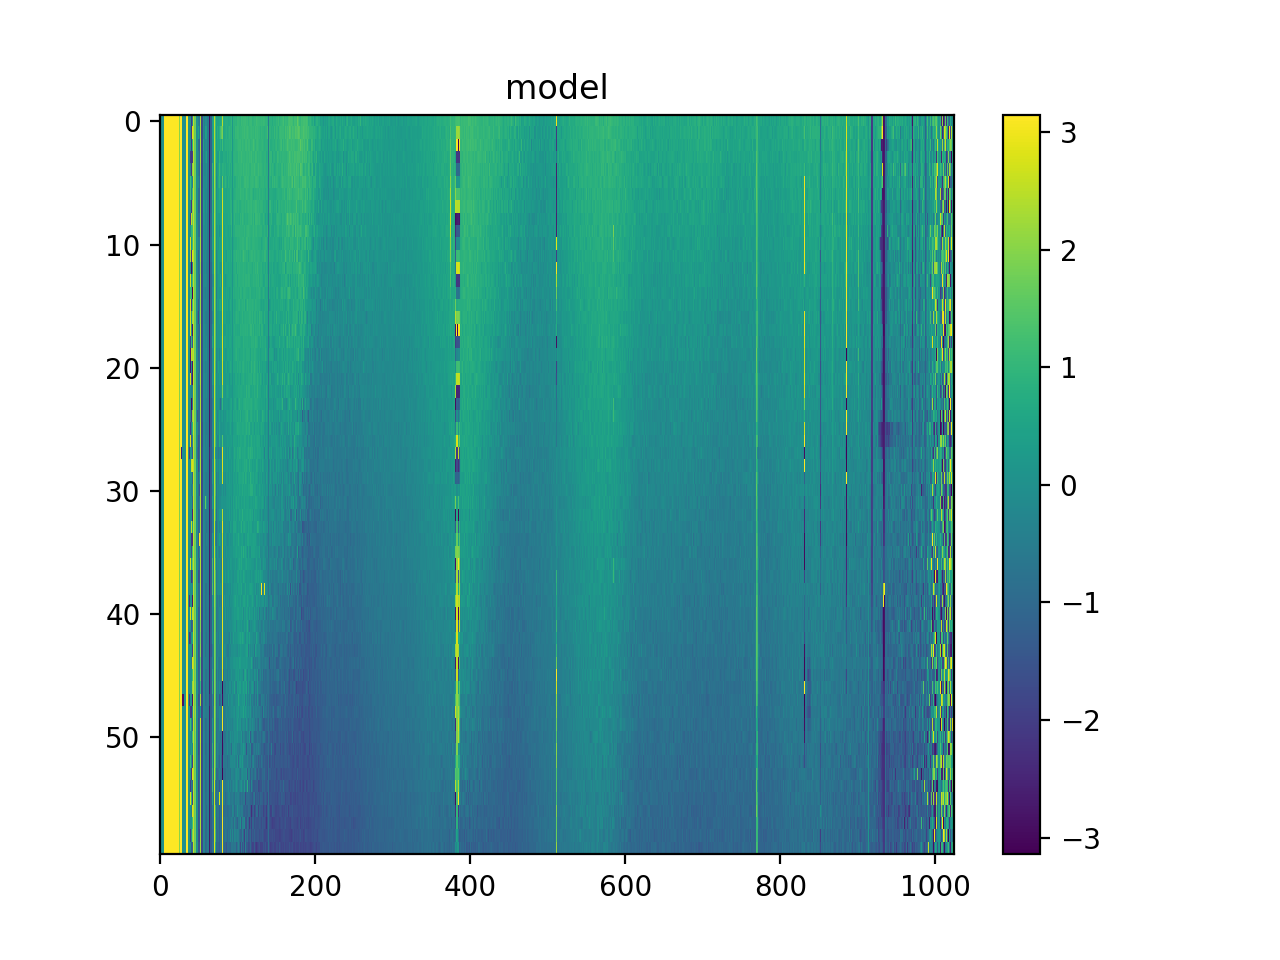

<IPython.core.display.Javascript object>


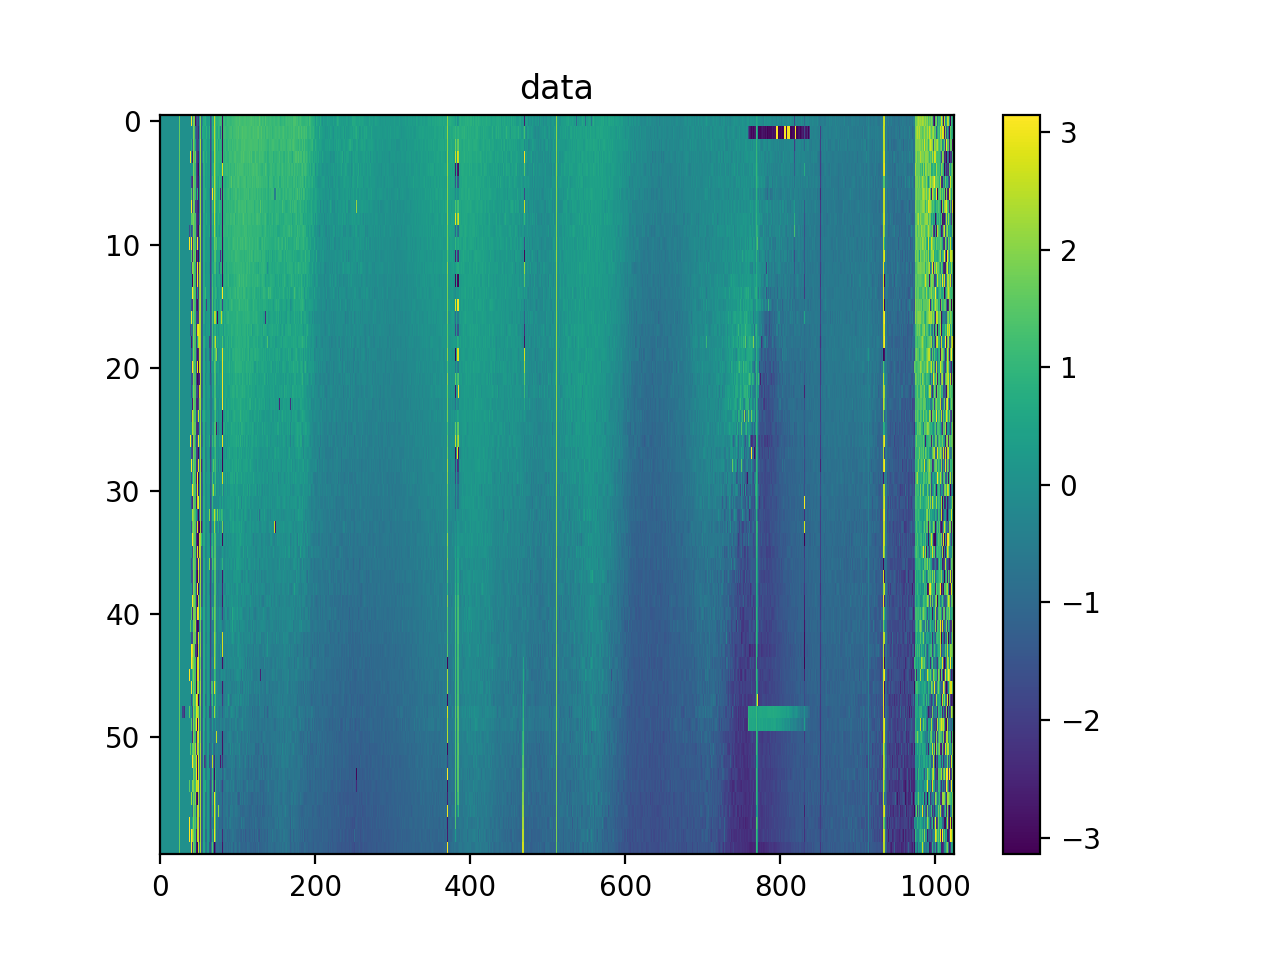

In [9]:
plt.figure()
plt.imshow(np.angle(new_model[54,55,'xx']), aspect='auto')
plt.colorbar()
plt.clim([-np.pi,np.pi])
plt.title('model')
plt.figure()
plt.imshow(np.angle(data[54,55,'xx']*1.0j), aspect='auto')
plt.colorbar()
plt.title('data')
plt.clim([-np.pi,np.pi])

<IPython.core.display.Javascript object>


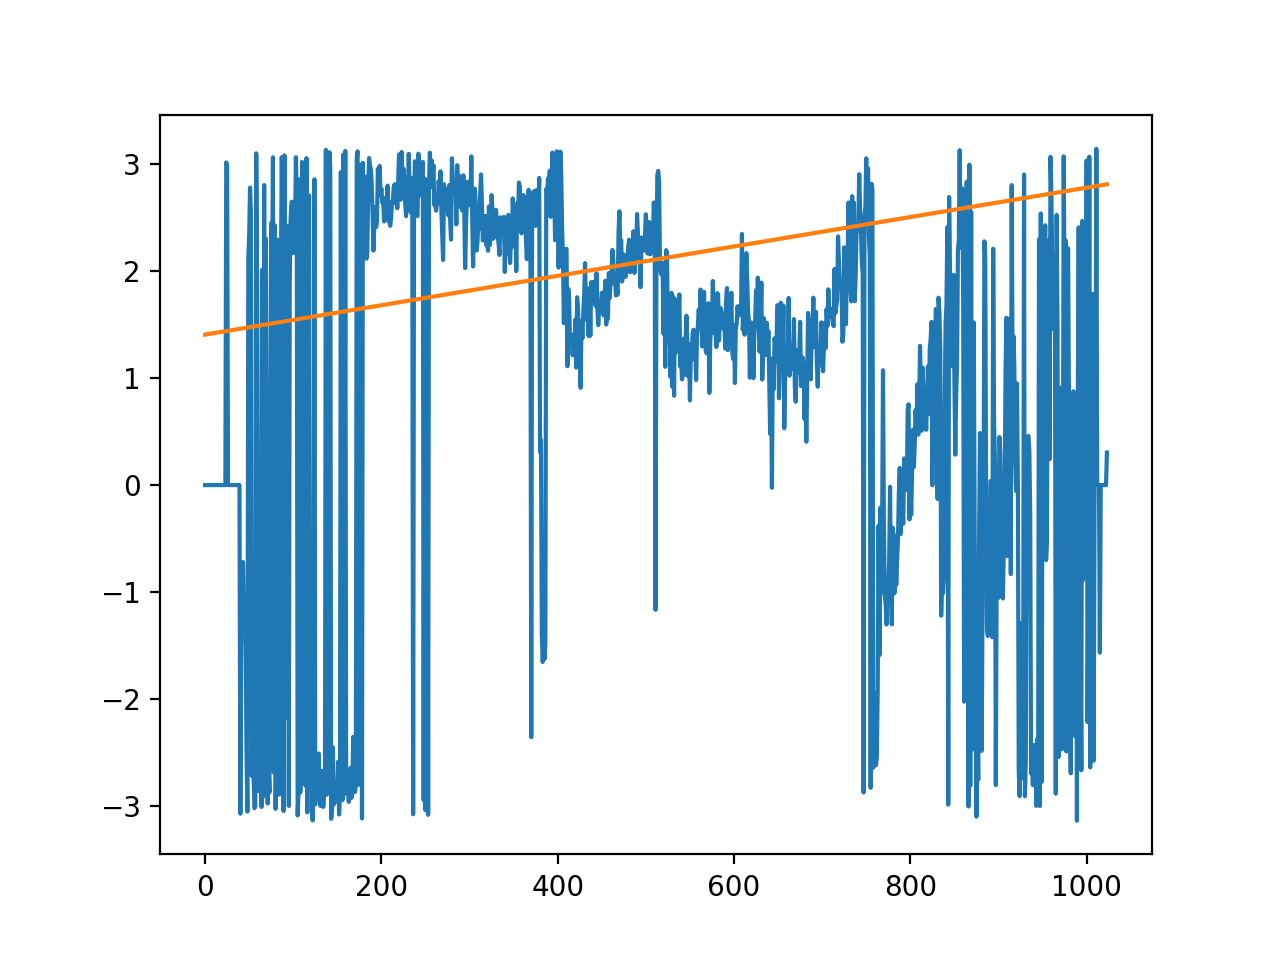

In [49]:
i=20
bl = (140,142,'xx')
plt.figure()
plt.plot(np.angle(data[bl]*np.conj(new_model[bl]))[i,:])
plt.plot(np.angle(AC.dly_slope_gain[bl[0],bl[2][0]] * np.conj(AC.dly_slope_gain[bl[1],bl[2][1]]))[i])

<IPython.core.display.Javascript object>


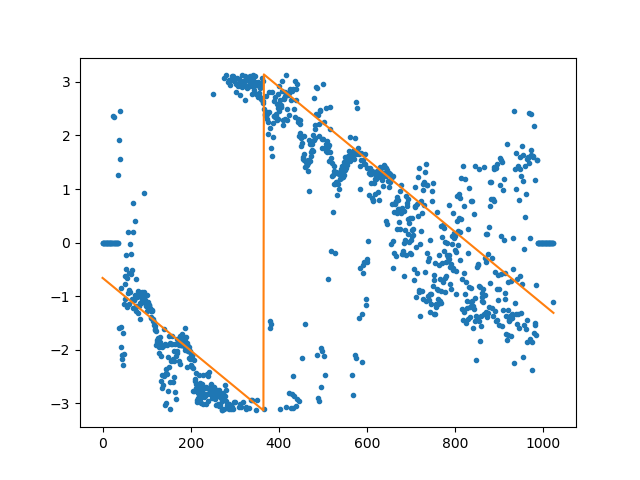

In [82]:
bl = (51,39,'xx')
plt.figure()
plt.plot(np.angle(np.median(data[bl]*np.conj(new_model[bl]),axis=0)),'.')
plt.plot(np.angle(AC.dly_slope_gain[bl[0],bl[2][0]] * np.conj(AC.dly_slope_gain[bl[1],bl[2][1]]))[1,:])

<IPython.core.display.Javascript object>


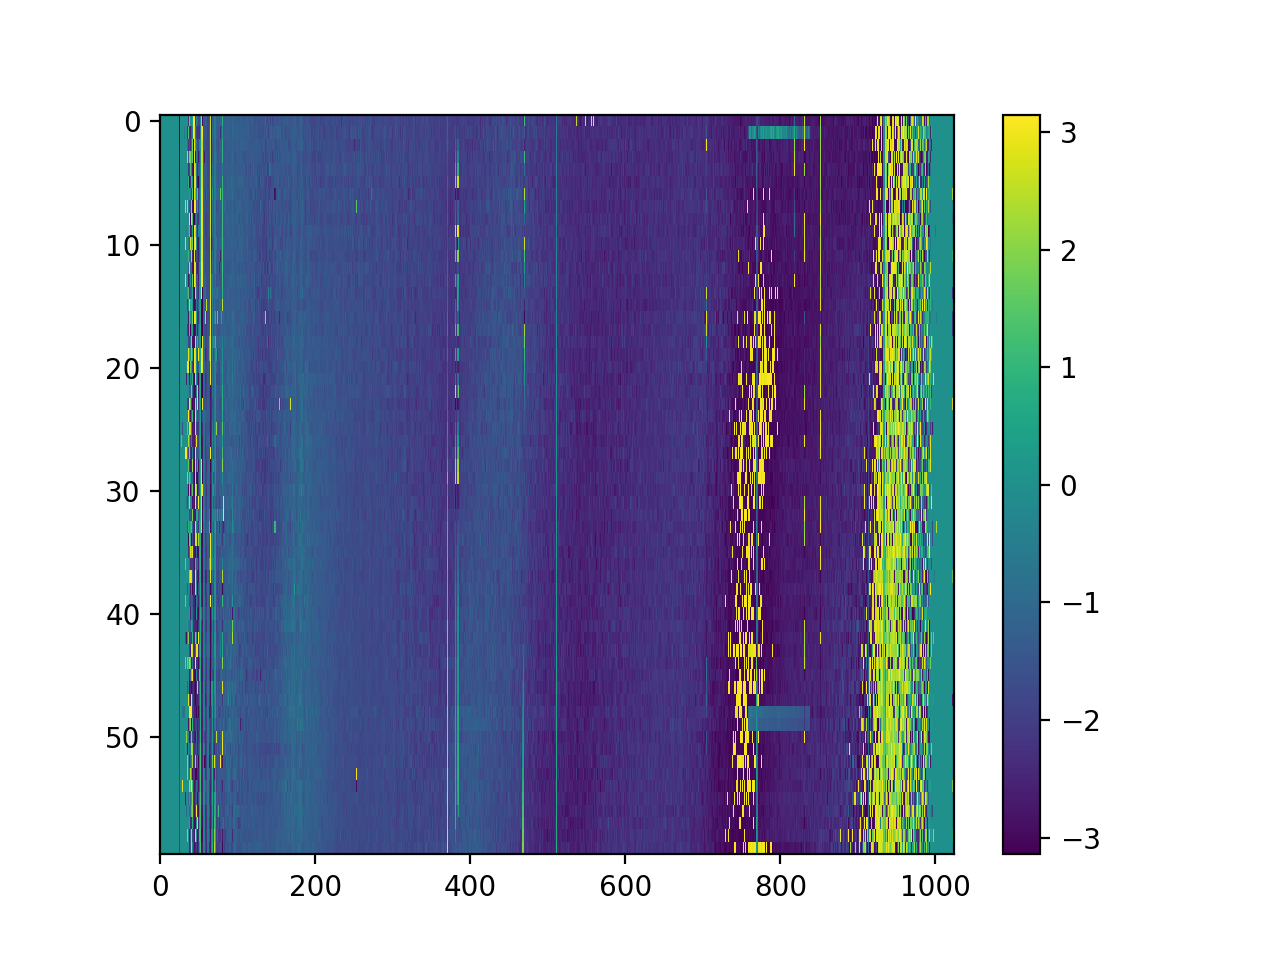

In [94]:
plt.figure()
plt.imshow(np.angle(data[bl]*np.conj(new_model[bl])), aspect='auto')
plt.colorbar()
plt.clim([-np.pi,np.pi])

In [89]:
time_avg = True
time_ax=0
freq_ax=1

In [87]:
# check for freq data
if AC.freqs is None:
    raise AttributeError("cannot delay_slope_lincal without self.freqs array")

# assign data
model = AC.model
data = copy.deepcopy(AC.data)
wgts = copy.deepcopy(AC.wgts)
antpos = AC.antpos


In [156]:
if time_avg:
    med_ratio = {}
    sum_wgts = {}
    ones = {}
    for bl in data.keys():
        data[bl][wgts[bl]==0] = np.nan
        med_ratio[bl] = np.nanmedian(data[bl] * np.conj(model[bl]) / np.abs(data[bl]) / np.abs(model[bl]), 
                                     axis=time_ax, keepdims=True)
        ones[bl] = np.ones_like(med_ratio[bl])
        sum_wgts[bl] = np.sum(wgts[bl], axis=time_ax, keepdims=True)
        sum_wgts[bl][np.isnan(med_ratio[bl])] = 0
        med_ratio[bl][np.isnan(med_ratio[bl])] = 0

<IPython.core.display.Javascript object>


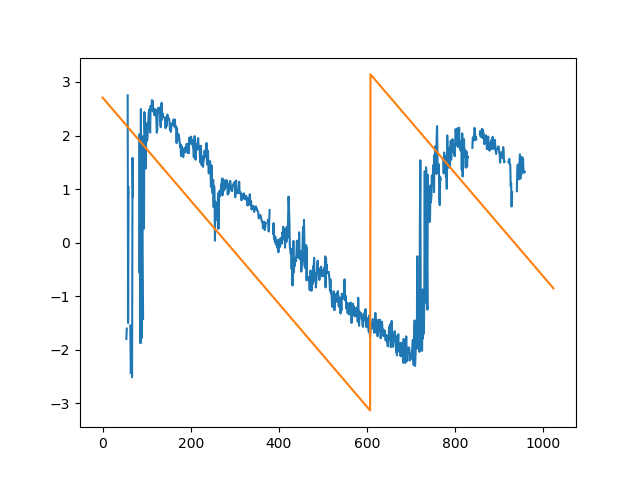

Invalid value encountered in median for 196 results


In [163]:
bl = (137, 143, 'xx')
plt.figure()
plt.plot(np.median(np.angle(data[bl] * np.conj(model[bl])), axis=0))
plt.plot(np.angle(np.exp(2.0j*np.pi*AC.freqs*fft_dly(med_ratio[bl], wgts=sum_wgts[bl])[0][0,0])))# - 
#         fft_dly(med_ratio[bl], wgts=sum_wgts[bl])[1][0,0])

In [137]:
AC.freqs

array([  1.00000000e+08,   1.00097656e+08,   1.00195312e+08, ...,
         1.99707031e+08,   1.99804688e+08,   1.99902344e+08])

In [116]:
fft_dly??

In [145]:
fft_dly(med_ratio[bl], wgts=sum_wgts[bl])[1]

(array([[ -7.24164301e-09]]), array([[-1.89925183]]))

In [107]:
sum_wgts[bl].shape#, med_ratio[bl].shape, ones[bl].shape

(1, 1024)

In [ ]:
fft_dly()